In [6]:
import requests
from pathlib import Path
import pandas as pd
import numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from ebmdatalab import bq
import os
import json
from pandas import json_normalize
import shutil
import matplotlib.ticker as mtick

DATA_FOLDER = Path("data/ccg_data_")
GITHUB_API_URL = 'https://api.github.com'
REPO_OWNER = 'ebmdatalab'
REPO_NAME = 'openprescribing'
PATH = 'openprescribing/measures/definitions'
CONTENT_URL = f'{GITHUB_API_URL}/repos/{REPO_OWNER}/{REPO_NAME}/contents/{PATH}'

In [21]:
def fetch_from_url(url):
    """Fetch the content from a given URL."""
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"Error fetching data from {url}: {e}")
        return None

def filter_json_files(file_list):
    """Filter files to only include those with a .json extension."""
    return [f for f in file_list if f['name'].endswith('.json')]

def extract_measure_names(file_list):
    """Extract measure names from a list of files."""
    measure_names = {}
    for file in file_list:
        name = file['name'].replace('.json', '')
        content_url = file['download_url']
        content_data = fetch_from_url(content_url)
        if content_data:
            measure_name = content_data.get('name', '')
            measure_names[name] = measure_name
    return measure_names

def cache_data(df, cache_path):
    """Cache the data to a CSV file."""
    df.to_csv(cache_path, index=False)

def load_cache(cache_path):
    """Load cached data from a CSV file if it exists."""
    if cache_path.exists():
        return pd.read_csv(cache_path)
    return None

def compute_deciles(measure_table, groupby_col, values_col, has_outer_percentiles=False):
    """
    Computes deciles.

    Args:
        measure_table (pd.DataFrame): A measure table.
        groupby_col (str): The name of the column to group by.
        values_col (str): The name of the column for which deciles are computed.
        has_outer_percentiles (bool, optional): Whether to compute the nine largest and nine smallest
            percentiles as well as the deciles. Defaults to False.

    Returns:
        pd.DataFrame: A data frame with `groupby_col`, `values_col`, and `percentile` columns.
    """
    
    quantiles = np.linspace(0.1, 0.9, 9)
    
    if has_outer_percentiles:
        lower_percentiles = np.linspace(0.01, 0.09, 9)
        upper_percentiles = np.linspace(0.91, 0.99, 9)
        quantiles = np.concatenate([lower_percentiles, quantiles, upper_percentiles])
    
    percentiles = (
        measure_table.groupby(groupby_col)[values_col]
        .quantile(quantiles)
        .reset_index()
    )
    
    percentiles["percentile"] = (percentiles["level_1"] * 100).astype(int)
    percentiles = percentiles[[groupby_col, "percentile", values_col]]
    
    return percentiles

def plot_percentiles(ax, deciles_lidocaine):
    """Plot percentiles on the given axes."""
    linestyles = {
        "decile": {"line": "b--", "linewidth": 1, "label": "Decile"},
        "median": {"line": "b-", "linewidth": 1.5, "label": "Median"},
        "percentile": {"line": "b:", "linewidth": 0.8, "label": "1st-9th, 91st-99th percentile"},
    }
    label_seen = []

    for percentile in range(1, 100):
        data = deciles_lidocaine[deciles_lidocaine["percentile"] == percentile]
        style = linestyles["median"] if percentile == 50 else linestyles["decile"]
        label = style["label"] if percentile == 50 or "decile" not in label_seen else "_nolegend_"
        if "decile" not in label_seen and percentile != 50:
            label_seen.append("decile")
        ax.plot(data["month"], data["rate"], style["line"], linewidth=style["linewidth"], label=label)

def plot_org_data(org, data, deciles, percentage, y_string):
    """Plot data for an organization along with deciles, medians, and change detection."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot percentiles
    plot_percentiles(ax, deciles)
    
    # Plot organization data
    df_subset = data[data["code"] == org]
    df_subset = df_subset.sort_values(by="month")
    ax.plot(df_subset["month"], df_subset["rate"], linewidth=2, color="red", label="Organisation Rate")
    
    ax.set_ylabel(y_string, size=14)
    if percentage: 
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0)) #  if percentage then use percentage formatter
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True)
    ax.tick_params(labelsize=16)
    ax.legend(fontsize=14)
    ax.margins(x=0)
    plt.tight_layout()
    plt.show()
    plt.close(fig)


In [13]:
DEFAULT_CONFIG = {
    'show_filter_results': False,
    'apply_start_end_percentile_filter': True,
    'start_percentile_threshold': 0.8,
    'end_percentile_threshold': 0.4,
    'apply_rate_decrease_filter': True,
    'rate_decrease_percent': 10,
    'apply_zero_filter': True,
    'apply_mean_events_filter': True,
    'mean_events_threshold': 50,
    'top_x_orgs': None,
}


class DataFrameProcessor:
    def __init__(self, df_main, config=None, verbose=False):
        self.df_main = df_main.sort_values(by="month")
        self.config = {**DEFAULT_CONFIG, **(config or {})}
        self.verbose = verbose

    def _print_change_counts(self, description, before, after):
        """Print the number of items before and after a filter is applied."""
        if self.verbose:
            print(f"{description} - Before: {before}, After: {after}\n---------")

    def _apply_filters(self):
        """Apply all filters based on the configuration."""
        filters = [
            ("apply_rate_decrease_filter", self._filter_by_rate_decrease),
            ("apply_mean_events_filter", self._filter_by_mean_events),
            ("apply_zero_filter", self._filter_going_to_zero),
            ("apply_start_end_percentile_filter", self._filter_by_start_end_percentile),
        ]

        filtered_df = self.df_main
        for conf_key, filter_func in filters:
            if self.config.get(conf_key):
                initial_count = filtered_df['code'].nunique()
                filtered_df = filter_func(filtered_df)
                if filtered_df.empty:
                    break
                self._print_change_counts(conf_key, initial_count, filtered_df['code'].nunique())
        
        top_x = self.config.get('top_x_orgs')
        if top_x:
            filtered_df = self._select_top_x_by_percentile_drop(filtered_df, top_x)

        self.df_main = filtered_df

    def _filter_going_to_zero(self, df):
        """Filter out orgs whose rates go to zero in the last six months."""
        goes_to_zero = df.groupby('code')['rate'].transform(lambda x: x.iloc[-6:].mean() == 0)
        return df[~goes_to_zero]

    def _filter_by_mean_events(self, df):
        """Filter orgs by a minimum threshold of mean events."""
        threshold = self.config.get('mean_events_threshold', 20)
        mean_events = df.groupby('code')['numerator'].transform('mean')
        return df[mean_events > threshold]

    def _filter_by_rate_decrease(self, df):
        """Filter orgs where the rate decreases by at least a certain percentage, handling division by zero."""
        decrease_percent = self.config.get("rate_decrease_percent", 10) / 100

        def calculate_rate_change(x):
            start_mean = x.iloc[:6].mean()
            end_mean = x.iloc[-6:].mean()
            
            if start_mean == 0:
                return None
            return (start_mean - end_mean) / start_mean

        rate_change = df.groupby('code')['rate'].apply(calculate_rate_change)
        valid_codes = rate_change.dropna()[rate_change >= decrease_percent].index
        return df[df['code'].isin(valid_codes)]

    def _filter_by_start_end_percentile(self, df):
        """Filter orgs that start in a high percentile and end in a low percentile."""
        start_threshold = self.config.get('start_percentile_threshold', 0.8)
        end_threshold = self.config.get('end_percentile_threshold', 0.4)
        
        start_percentile = df.groupby('code').apply(lambda x: x['percentile'].iloc[:6].mean())
        end_percentile = df.groupby('code').apply(lambda x: x['percentile'].iloc[-6:].mean())
        valid_orgs = start_percentile[start_percentile > start_threshold].index.intersection(end_percentile[end_percentile < end_threshold].index)
        return df[df['code'].isin(valid_orgs)]
    
    def _select_top_x_by_percentile_drop(self, df, top_x):
        """Selects the top x organizations based on the largest percentile drop."""
        
        start_percentile = df.groupby('code')['percentile'].transform(lambda x: x.iloc[:6].mean())
        end_percentile = df.groupby('code')['percentile'].transform(lambda x: x.iloc[-6:].mean())

        df['percentile_drop'] = start_percentile - end_percentile
        
        top_x_codes = (df[['code', 'percentile_drop']]
                       .drop_duplicates('code')
                       .sort_values(by='percentile_drop', ascending=False)
                       .head(top_x)['code'])

        return df[df['code'].isin(top_x_codes)]

    def apply_combined_filters(self):
        self._apply_filters()
        return self.df_main['code'].unique().tolist()

In [9]:
config = {
    'show_filter_results': False,
    'apply_start_end_percentile_filter': True,
    'start_percentile_threshold': 0.8,
    'end_percentile_threshold': 0.5,
    'apply_rate_decrease_filter': True,
    'rate_decrease_percent': 5,
    'apply_zero_filter': True,
    'apply_mean_events_filter': True,
    'mean_events_threshold': 50,
    'top_x_orgs': 5,
}

In [15]:
#get latest measures list and refresh data
res = requests.get('https://api.github.com/repos/ebmdatalab/openprescribing/contents/openprescribing/measures/definitions') #uses GitHub API to get list of all files listed in measure definitions - defaults to main branch
data = res.text #creates text from API result
df = pd.read_json(data) #turns JSON from API result into dataframe
json_df = pd.DataFrame() #creates blank dataframe
for row in df[df['name'].str.contains('.json')].itertuples(index=True): #iterates through rows, and continues if file is .json
        url = (getattr(row, "download_url")) #gets URL from API request  
        data = json.loads(requests.get(url).text) #gets JSON from measure definition URL
        norm_df = pd.json_normalize(data, max_level=1) #normalises measure definition JSON into dataframe
        json_df = pd.concat([json_df,norm_df], axis=0, ignore_index=True) # concatentates into single dataframe
        json_df['table_id'] = 'ccg_data_' + df['name'].str.split('.').str[0].copy()
tags_df = json_df.explode('tags') # explode json so each tag is on seperate line
core_df = tags_df[['table_id', 'name', 'tags', 'radar_exclude', 'is_percentage','numerator_short', 'denominator_short']].copy() # create smaller df based on tags_df
core_df['measure_name'] = core_df['table_id'].apply(lambda x: x.replace('ccg_data_', '')) # remove `ccg_data_` from measure_name for use in URL
core_df['y_string'] = core_df['numerator_short'] + ' per ' +  core_df['denominator_short']
measure_list = core_df[((core_df['tags'].str.contains('core')) | (core_df['tags'].str.contains('lowpriority'))) & (core_df['radar_exclude'] != 'True')] #filter to only core measures where `radar_exclude` is not true
measure_list.to_csv(DATA_FOLDER / 'measure_list.csv', index=False)  #save measure_list

#create for next loop to go through each table name in the previous query
for name in measure_list['table_id']:
    
    sql = """
    SELECT
      month, 
      pct_id as code, 
      numerator, 
      denominator, 
    FROM
      `ebmdatalab.measures.{}` AS a
    """
    
    sql = sql.format(name) #using python string to add table_name to SQL
    #concatenate each table name into single file during for next loop
    bq.cached_read(sql, os.path.join(DATA_FOLDER, "{}", "bq_cache.csv").format(name), use_cache=False)
    
#delete any unused measure folders
for folder in os.listdir(DATA_FOLDER):
    if os.path.isdir(os.path.join(DATA_FOLDER, folder)):  # Check if it's a directory
        if folder not in measure_list['table_id'].values:  # Check if folder is not in DataFrame
            # Delete the folder and its contents
            folder_path = os.path.join(DATA_FOLDER, folder)
            shutil.rmtree(folder_path)

Downloading: 100%|██████████| 6466/6466 [00:00<00:00, 12550.75rows/s]


In [11]:
#get SICBL names
sql = """
    SELECT
      code, 
      name 
    FROM
      ebmdatalab.hscic.ccgs
    WHERE
      name IS NOT NULL
    GROUP BY
      code, 
      name     
    """
ccg_names = bq.cached_read(sql, os.path.join(DATA_FOLDER, "ccg_names.csv"), use_cache=False)

Downloading: 100%|██████████| 457/457 [00:00<00:00, 4014.37rows/s]


# OpenPrescribing Improvement Radar

## What this tool does
This tool identifies sub-ICB locations (SICBLs) which have shown substantial improvement across each of our OpenPrescribing measures. The five SICBLs with the largest improvement are reported. We hope this will stimulate discussion with areas that have made effective changes so that successful strategies can be shared.

## How it works
We used trend indicator saturation to detect the timing and size of changes of SICBLs against all SICBLs in England. This prototype uses the current criteria to identify improvement:
* SICBLs needed to, on average, be in the highest 20% during the first 6 months of the time period shown.
* SICBLs needed to improve to be, on average, in the lowest 50% of SICBLs during the last 6 months of the period shown.
* The rate of the measure has to decrease by at least 5% across the time period shown (calculated as the difference between the average rate for the first 6 months and the last 6 months). 
* There needed to be, on average, at least 50 prescription items written.

You can find more information on the trend indicator saturation methodology we use [here](https://www.bmj.com/content/367/bmj.l5205), including a podcast on our work with Professor Ben Goldacre.

## Interpretation notes
These pilot results are provided for the interest of advanced users, although we don't know how relevant they are in practice. There is substantial variation in prescribing behaviours, across various different areas of medicine. Some variation can be explained by demographic changes, or local policies or guidelines, but much of the remaining variation is less easy to explain.

We are keen to hear your feedback on this tool and how you use it. You can do this by emailing us at bennett@phc.ox.ac.uk. Please do not include patient identifiable information in your feedback.


## Table of Contents

<a href=#injectable_antibiotics>- Antibiotic stewardship: Injectable preparations for the treatment of infection</a>

<a href=#ktt9_cephalosporins>- Antibiotic stewardship: co-amoxiclav, cephalosporins & quinolones (KTT9)</a>

<a href=#ktt9_cephalosporins_star>- Antibiotic stewardship: co-amoxiclav, cephalosporins & quinolones (KTT9) prescribing volume</a>

<a href=#amox_500_15_caps>- Antibiotic stewardship: courses for amoxicillin 500mg greater than 15 capsules</a>

<a href=#doxy_100_6_qty>- Antibiotic stewardship: courses for doxycycline 100mg greater than 6 capsules/dispersible tablets</a>

<a href=#uti_antibiotics_3_day>- Antibiotic stewardship: three-day courses for uncomplicated UTIs</a>

<a href=#ktt9_antibiotics>- Antibiotic stewardship: volume of antibiotic prescribing (KTT9)</a>

<a href=#bdzper1000>- Anxiolytics and Hypnotics: Average Daily Quantity per 1000 patients</a>

<a href=#bdzadq>- Anxiolytics and Hypnotics: Average Daily Quantity per item</a>

<a href=#other_lipid_modifying_drugs>- Bile acid sequestrants, fibrates, nicotinic acid, and omega 3 fatty acids</a>

<a href=#nhse_lancets>- Blood glucose testing lancets not included in NHS England commissioning recommendations</a>

<a href=#nhse_bgts>- Blood glucose testing strips not included in NHS England commissioning recommendations</a>

<a href=#ciclosporin>- Ciclosporin and tacrolimus oral preparations prescribed generically</a>

<a href=#coproxamol>- Co-proxamol</a>

<a href=#cmpaperpt>- Cost of milk formulae for Cow's Milk Protein Allergy (CMPA) per listed patients aged 0-4</a>

<a href=#diltiazem>- Diltiazem preparations (>60mg) prescribed generically</a>

<a href=#carbon_salbutamol>- Environmental impact of inhalers - average carbon footprint per salbutamol inhaler</a>

<a href=#environmental_inhalers>- Environmental impact of inhalers - prescribing of non-salbutamol Metered Dose Inhalers (MDIs)</a>

<a href=#icsdose>- High dose inhaled corticosteroids</a>

<a href=#opioidspercent>- High dose opioid items as percentage regular opioids</a>

<a href=#opioidper1000>- High dose opioids per 1000 patients</a>

<a href=#sildenafil>- High-cost drugs for erectile dysfunction</a>

<a href=#ppidose>- Higher dose Proton Pump Inhibitors (PPIs)</a>

<a href=#lpbathshoweremollients>- Items which should not routinely be prescribed in primary care  - bath and shower emollients</a>

<a href=#lpaliskiren>- Items which should not routinely be prescribed in primary care - aliskiren</a>

<a href=#lpzomnibus>- Items which should not routinely be prescribed in primary care - all items</a>

<a href=#lpamiodarone>- Items which should not routinely be prescribed in primary care - amiodarone</a>

<a href=#lpcoprox>- Items which should not routinely be prescribed in primary care - co-proxamol</a>

<a href=#lpdosulepin>- Items which should not routinely be prescribed in primary care - dosulepin</a>

<a href=#lpdoxazosin>- Items which should not routinely be prescribed in primary care - doxazosin modified release</a>

<a href=#lpdronedarone>- Items which should not routinely be prescribed in primary care - dronedarone</a>

<a href=#lpglucosamine>- Items which should not routinely be prescribed in primary care - glucosamine and chondroitin</a>

<a href=#lpherbal>- Items which should not routinely be prescribed in primary care - herbal medicines</a>

<a href=#lphomeopathy>- Items which should not routinely be prescribed in primary care - homeopathy</a>

<a href=#lpfentanylir>- Items which should not routinely be prescribed in primary care - immediate release fentanyl</a>

<a href=#lpneedles>- Items which should not routinely be prescribed in primary care - insulin pen needles costing ≥£5 per 100 needles</a>

<a href=#lplidocaine>- Items which should not routinely be prescribed in primary care - lidocaine plasters</a>

<a href=#lpliothyronine>- Items which should not routinely be prescribed in primary care - liothyronine (including Armour Thyroid and liothyronine combination products)</a>

<a href=#lplutein>- Items which should not routinely be prescribed in primary care - lutein and antioxidants</a>

<a href=#lpminocycline>- Items which should not routinely be prescribed in primary care - minocycline</a>

<a href=#lpomega3>- Items which should not routinely be prescribed in primary care - omega-3 fatty acid compounds (excluding icosapent ethyl [Vazkepa®])</a>

<a href=#lpoxycodone>- Items which should not routinely be prescribed in primary care - oxycodone and naloxone combination product</a>

<a href=#lptramadolpara>- Items which should not routinely be prescribed in primary care - paracetamol and tramadol combination</a>

<a href=#lpperindopril>- Items which should not routinely be prescribed in primary care - perindopril arginine</a>

<a href=#lprubefacients>- Items which should not routinely be prescribed in primary care - rubefacients, benzydamine, mucopolysaccharide and cooling products</a>

<a href=#lpsilkgarments>- Items which should not routinely be prescribed in primary care - silk garments</a>

<a href=#lptravelvacs>- Items which should not routinely be prescribed in primary care - travel vaccines</a>

<a href=#lptrimipramine>- Items which should not routinely be prescribed in primary care - trimipramine</a>

<a href=#ktt12_diabetes_insulin>- Long-acting insulin analogues (KTT12)</a>

<a href=#statinintensity>- Low and medium intensity statins</a>

<a href=#methotrexate>- Methotrexate 10 mg tablets </a>

<a href=#ktt13_nsaids_ibuprofen>- Non-preferred NSAIDs and COX-2 inhibitors (KTT13)</a>

<a href=#semagglutidequantity>- Possible excess quantities of semaglutide</a>

<a href=#aafpercent>- Prescribing of Amino Acid Formula (AAF) and Extensively Hydrolysed Formula (EHF))</a>

<a href=#cgm_sensors>- Prescribing of continuous glucose monitoring sensors</a>

<a href=#dipyridamole>- Prescribing of dipyridamole</a>

<a href=#gabapentinoidsddd>- Prescribing of gabapentin and pregabalin (DDD)</a>

<a href=#glutenfree>- Prescribing of gluten free products</a>

<a href=#opioidome>- Prescribing of opioids (total oral morphine equivalence)</a>

<a href=#pregabalinmg>- Prescribing of pregabalin (total mg)</a>

<a href=#probiotics>- Probiotics that have been removed from the drug tariff</a>

<a href=#edoxaban>- Proportion of Direct Acting Oral Anticoagulants (DOACs) not prescribed as edoxaban or generic apixaban</a>

<a href=#seven_day_prescribing>- Seven Day Prescribing for Long Term Conditions</a>

<a href=#saba>- Short acting beta agonist inhalers</a>

<a href=#silver>- Silver dressings</a>

<a href=#solublepara>- Soluble/effervescent forms of paracetamol and co-codamol</a>

<a href=#toothpaste>- Toothpaste Prescribing</a>

<a href=#fungal>- Topical treatment of fungal nail infections</a>

<a href=#vitbper1000>- Vitamin B complex per 1000 patients</a>

<h2 id=injectable_antibiotics><a href=https://openprescribing.net/measure/injectable_antibiotics>Antibiotic stewardship: Injectable preparations for the treatment of infection</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=ktt9_cephalosporins><a href=https://openprescribing.net/measure/ktt9_cephalosporins>Antibiotic stewardship: co-amoxiclav, cephalosporins & quinolones (KTT9)</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=ktt9_cephalosporins_star><a href=https://openprescribing.net/measure/ktt9_cephalosporins_star>Antibiotic stewardship: co-amoxiclav, cephalosporins & quinolones (KTT9) prescribing volume</a></h2>

<h4><a href=https://openprescribing.net/measure/ktt9_cephalosporins_star/sicbl/00P>NHS SUNDERLAND</a></h4>

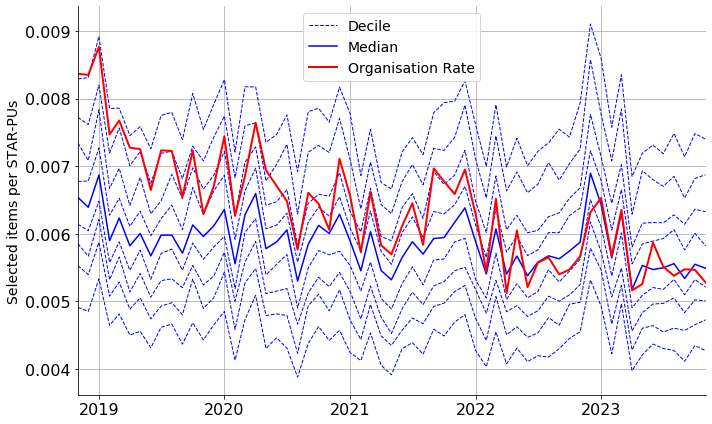

<h4><a href=https://openprescribing.net/measure/ktt9_cephalosporins_star/sicbl/99E>NHS BASILDON AND BRENTWOOD</a></h4>

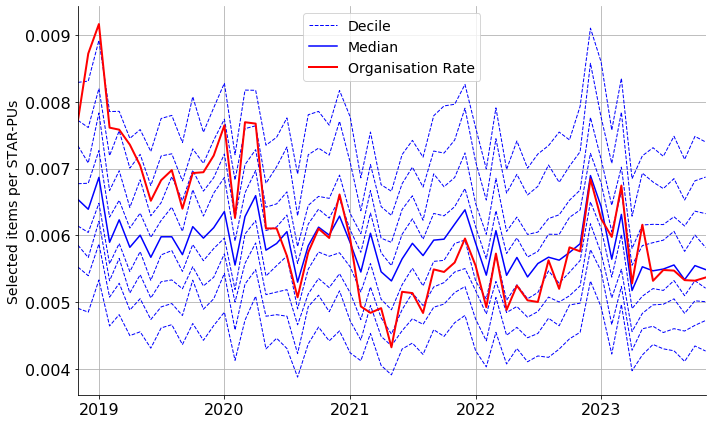

<h2 id=amox_500_15_caps><a href=https://openprescribing.net/measure/amox_500_15_caps>Antibiotic stewardship: courses for amoxicillin 500mg greater than 15 capsules</a></h2>

<h4><a href=https://openprescribing.net/measure/amox_500_15_caps/sicbl/01G>NHS SALFORD</a></h4>

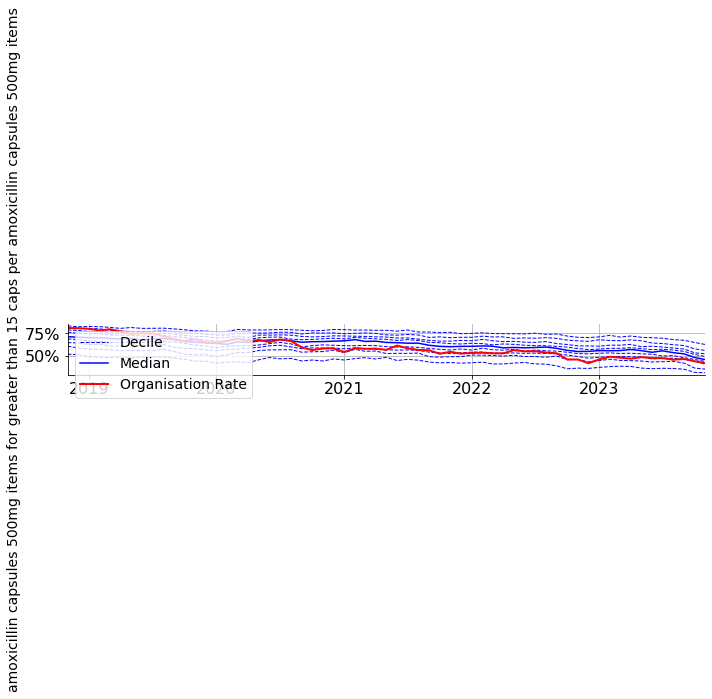

<h4><a href=https://openprescribing.net/measure/amox_500_15_caps/sicbl/02T>NHS CALDERDALE</a></h4>

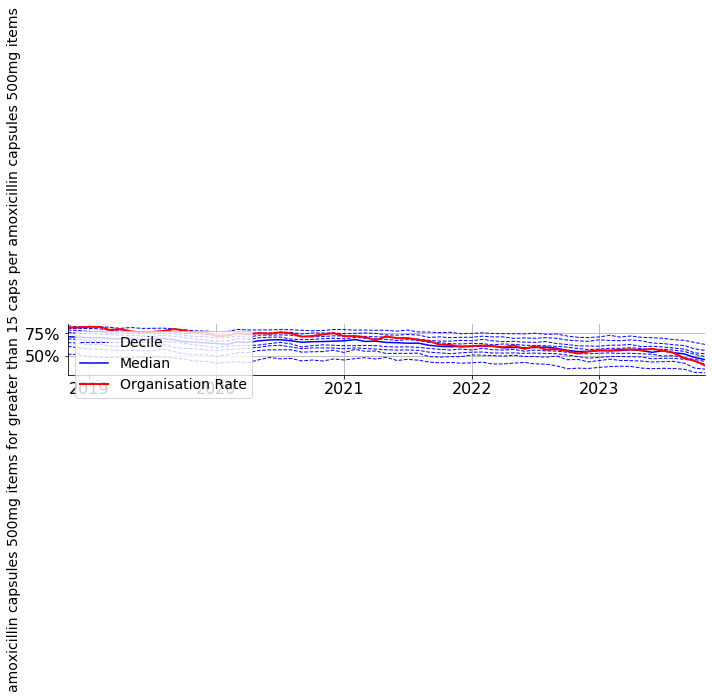

<h4><a href=https://openprescribing.net/measure/amox_500_15_caps/sicbl/07H>NHS WEST ESSEX</a></h4>

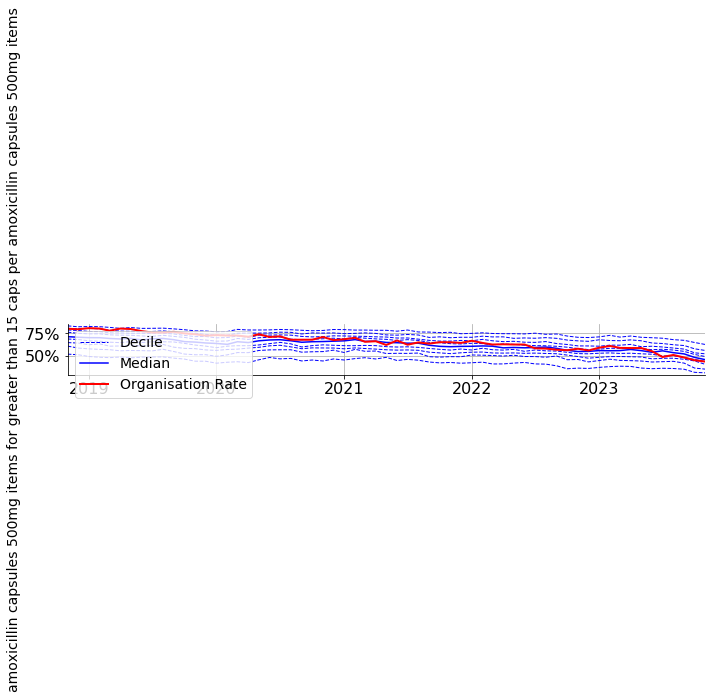

<h4><a href=https://openprescribing.net/measure/amox_500_15_caps/sicbl/15N>NHS DEVON</a></h4>

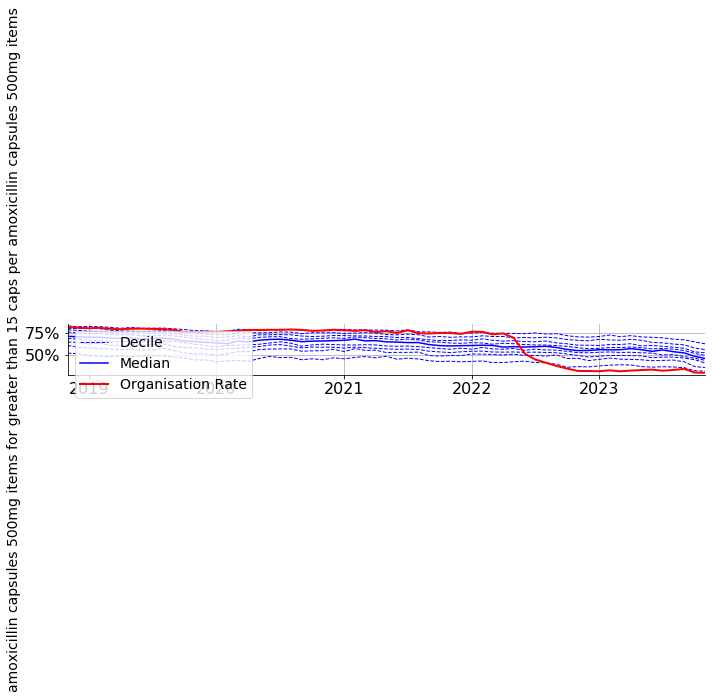

<h4><a href=https://openprescribing.net/measure/amox_500_15_caps/sicbl/02E>NHS WARRINGTON</a></h4>

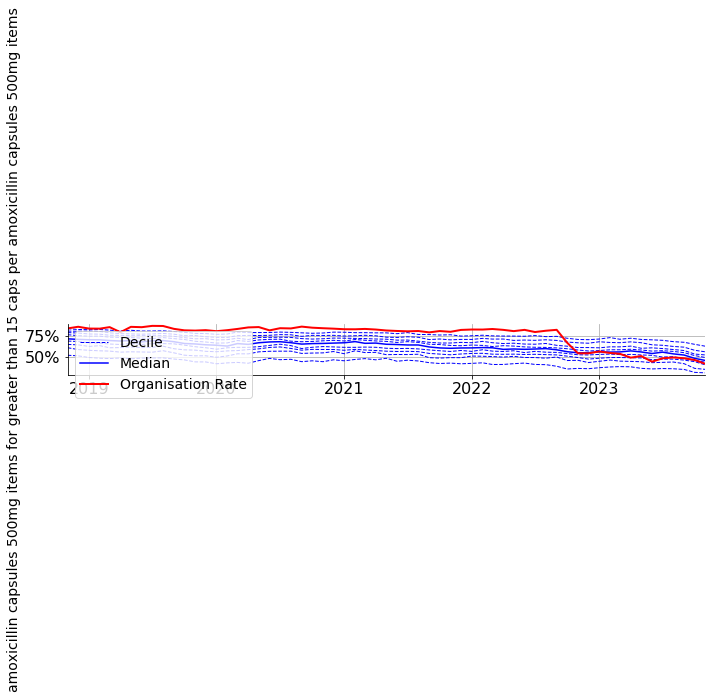

<h2 id=doxy_100_6_qty><a href=https://openprescribing.net/measure/doxy_100_6_qty>Antibiotic stewardship: courses for doxycycline 100mg greater than 6 capsules/dispersible tablets</a></h2>

<h4><a href=https://openprescribing.net/measure/doxy_100_6_qty/sicbl/03N>NHS SHEFFIELD</a></h4>

<ipython-input-21-2f36c4ab574a>:108: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


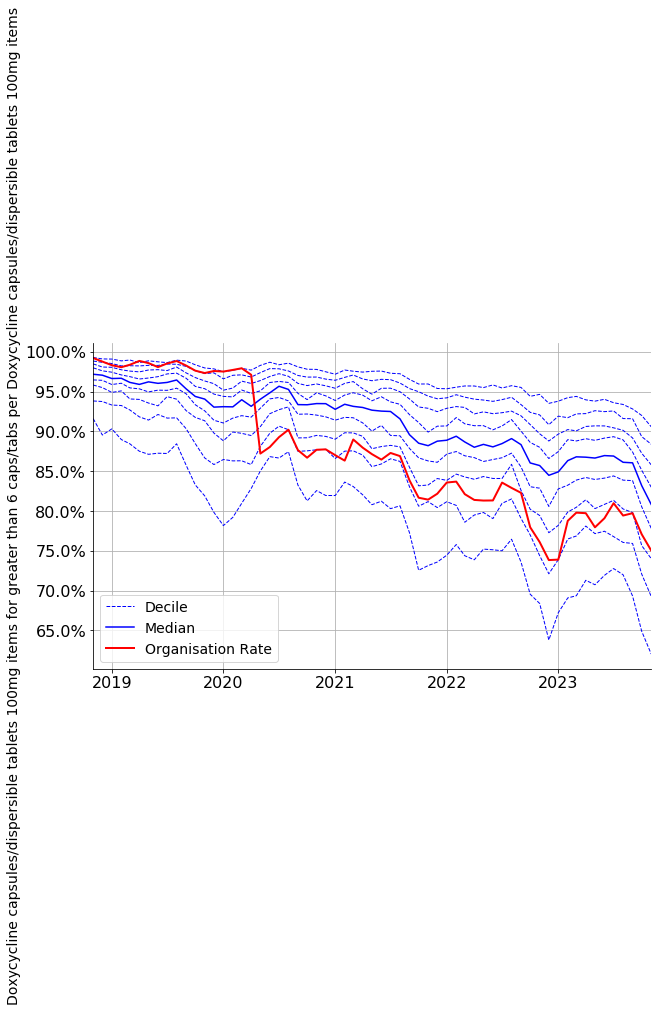

<h4><a href=https://openprescribing.net/measure/doxy_100_6_qty/sicbl/03H>NHS NORTH EAST LINCOLNSHIRE</a></h4>

<ipython-input-21-2f36c4ab574a>:108: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


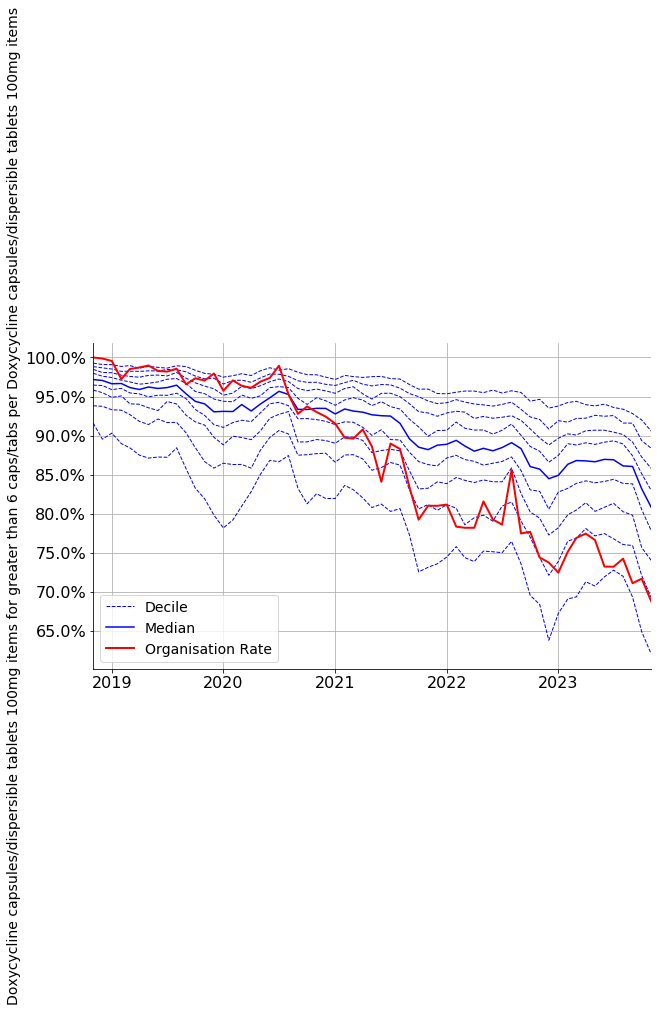

<h4><a href=https://openprescribing.net/measure/doxy_100_6_qty/sicbl/X2C4Y>NHS KIRKLEES</a></h4>

<ipython-input-21-2f36c4ab574a>:108: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


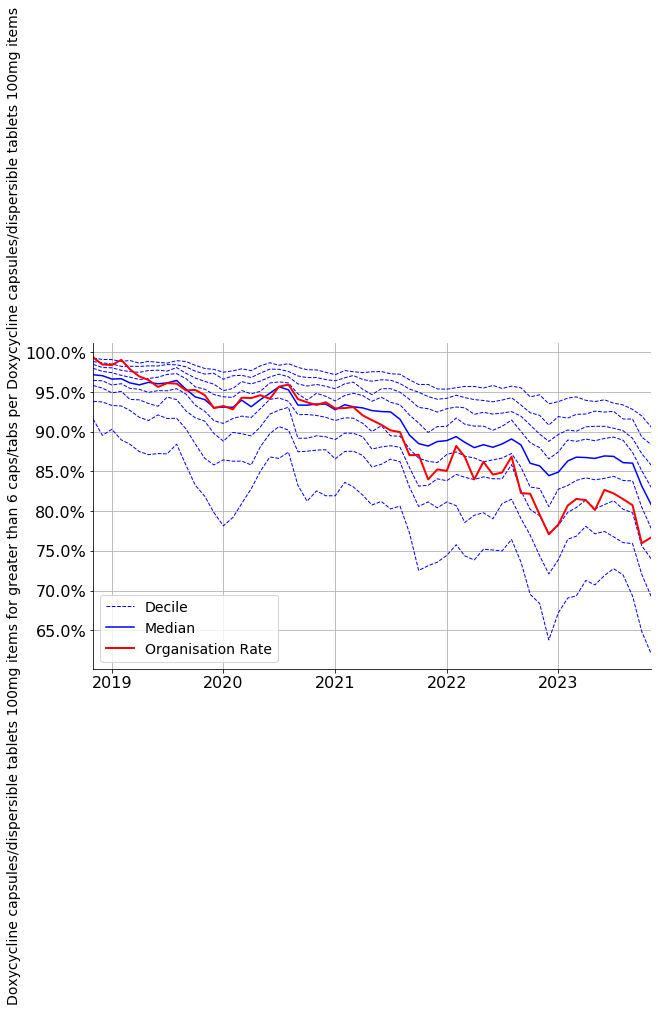

<h2 id=uti_antibiotics_3_day><a href=https://openprescribing.net/measure/uti_antibiotics_3_day>Antibiotic stewardship: three-day courses for uncomplicated UTIs</a></h2>

<h4><a href=https://openprescribing.net/measure/uti_antibiotics_3_day/sicbl/03L>NHS ROTHERHAM</a></h4>

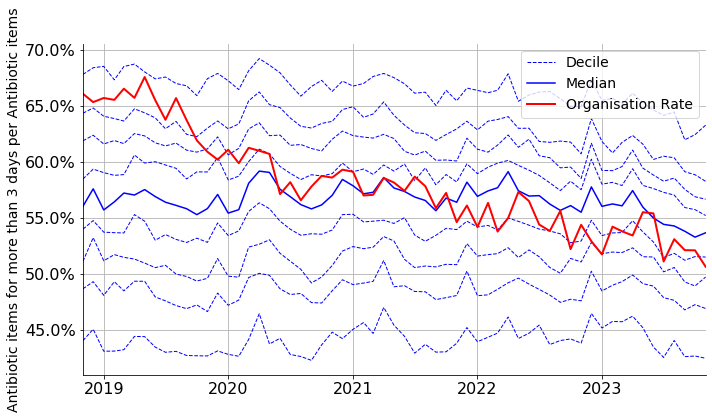

<h2 id=ktt9_antibiotics><a href=https://openprescribing.net/measure/ktt9_antibiotics>Antibiotic stewardship: volume of antibiotic prescribing (KTT9)</a></h2>

<h4><a href=https://openprescribing.net/measure/ktt9_antibiotics/sicbl/99E>NHS BASILDON AND BRENTWOOD</a></h4>

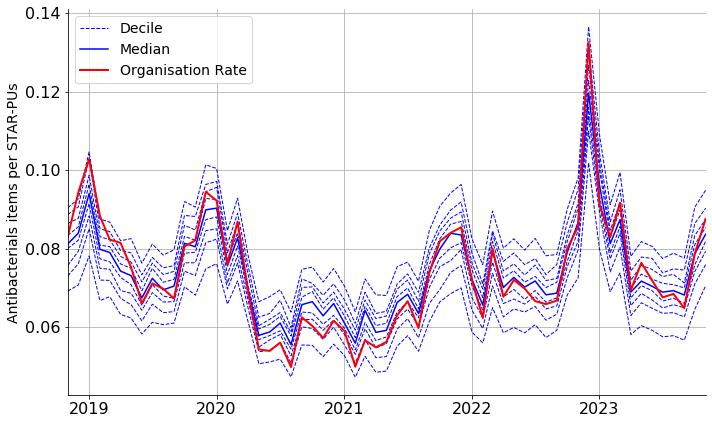

<h2 id=bdzper1000><a href=https://openprescribing.net/measure/bdzper1000>Anxiolytics and Hypnotics: Average Daily Quantity per 1000 patients</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=bdzadq><a href=https://openprescribing.net/measure/bdzadq>Anxiolytics and Hypnotics: Average Daily Quantity per item</a></h2>

<h4><a href=https://openprescribing.net/measure/bdzadq/sicbl/01D>NHS HEYWOOD, MIDDLETON AND ROCHDALE</a></h4>

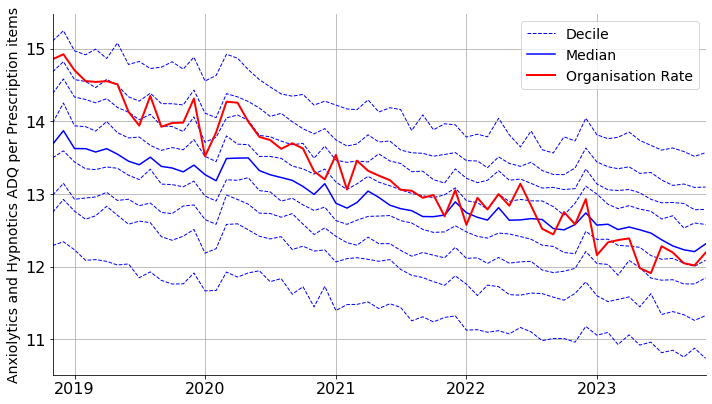

<h2 id=other_lipid_modifying_drugs><a href=https://openprescribing.net/measure/other_lipid_modifying_drugs>Bile acid sequestrants, fibrates, nicotinic acid, and omega 3 fatty acids</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=nhse_lancets><a href=https://openprescribing.net/measure/nhse_lancets>Blood glucose testing lancets not included in NHS England commissioning recommendations</a></h2>

<h4><a href=https://openprescribing.net/measure/nhse_lancets/sicbl/00X>NHS CHORLEY AND SOUTH RIBBLE</a></h4>

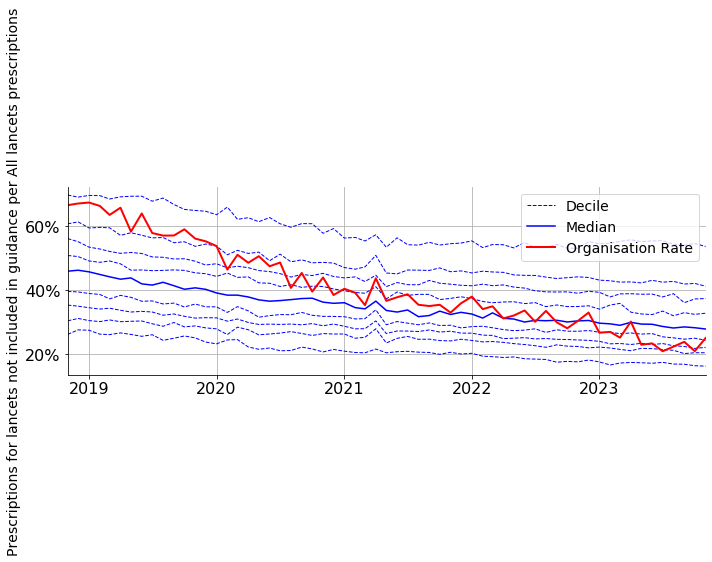

<h4><a href=https://openprescribing.net/measure/nhse_lancets/sicbl/36J>NHS BRADFORD DISTRICT AND CRAVEN</a></h4>

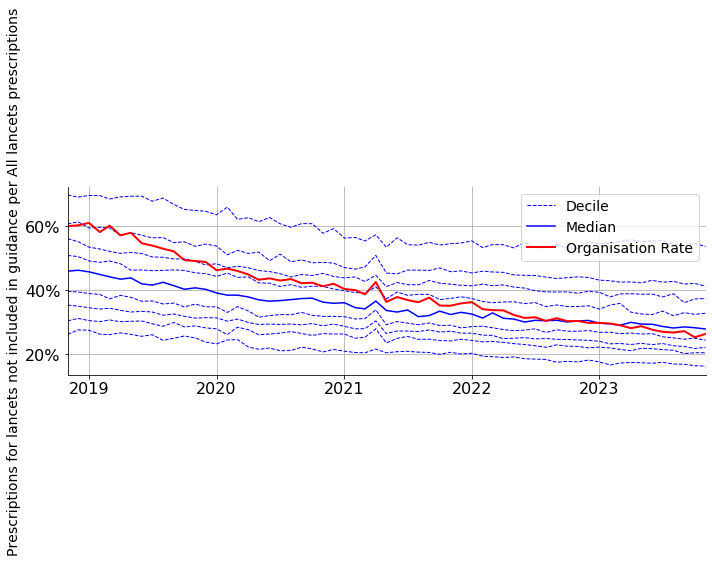

<h2 id=nhse_bgts><a href=https://openprescribing.net/measure/nhse_bgts>Blood glucose testing strips not included in NHS England commissioning recommendations</a></h2>

<h4><a href=https://openprescribing.net/measure/nhse_bgts/sicbl/04C>NHS LEICESTER CITY</a></h4>

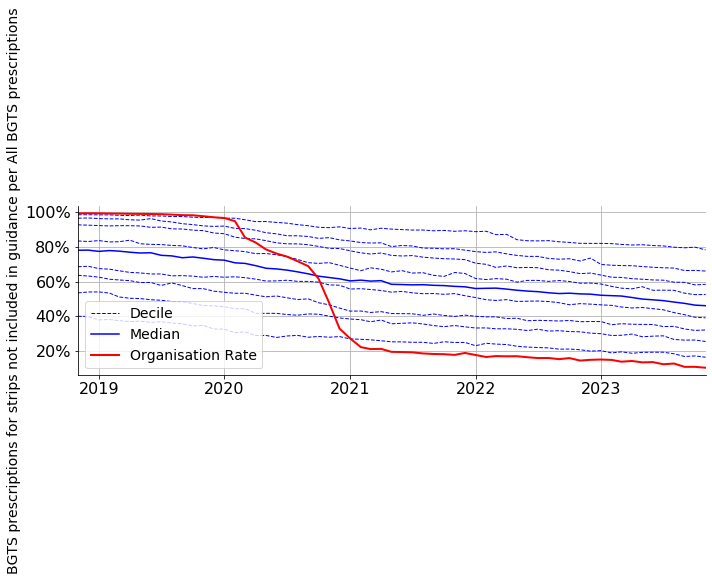

<h4><a href=https://openprescribing.net/measure/nhse_bgts/sicbl/03W>NHS EAST LEICESTERSHIRE AND RUTLAND</a></h4>

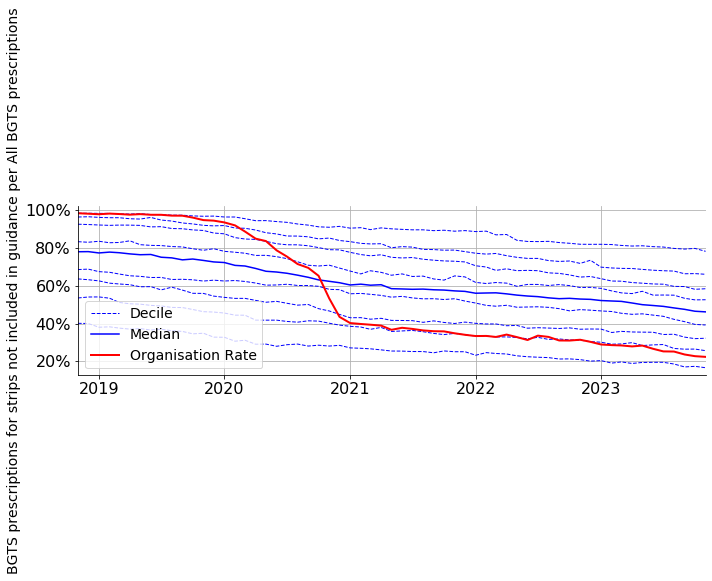

<h4><a href=https://openprescribing.net/measure/nhse_bgts/sicbl/04V>NHS WEST LEICESTERSHIRE</a></h4>

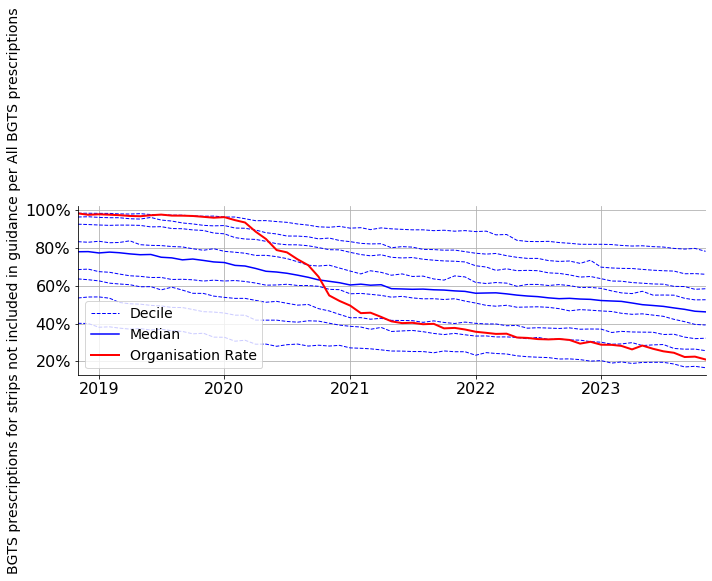

<h2 id=ciclosporin><a href=https://openprescribing.net/measure/ciclosporin>Ciclosporin and tacrolimus oral preparations prescribed generically</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=coproxamol><a href=https://openprescribing.net/measure/coproxamol>Co-proxamol</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=cmpaperpt><a href=https://openprescribing.net/measure/cmpaperpt>Cost of milk formulae for Cow's Milk Protein Allergy (CMPA) per listed patients aged 0-4</a></h2>

<h4><a href=https://openprescribing.net/measure/cmpaperpt/sicbl/42D>NHS NORTH YORKSHIRE</a></h4>

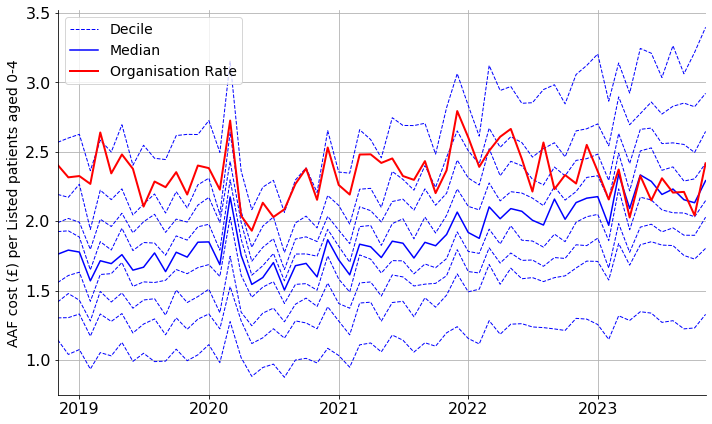

<h2 id=diltiazem><a href=https://openprescribing.net/measure/diltiazem>Diltiazem preparations (>60mg) prescribed generically</a></h2>

<h4><a href=https://openprescribing.net/measure/diltiazem/sicbl/12F>NHS WIRRAL</a></h4>

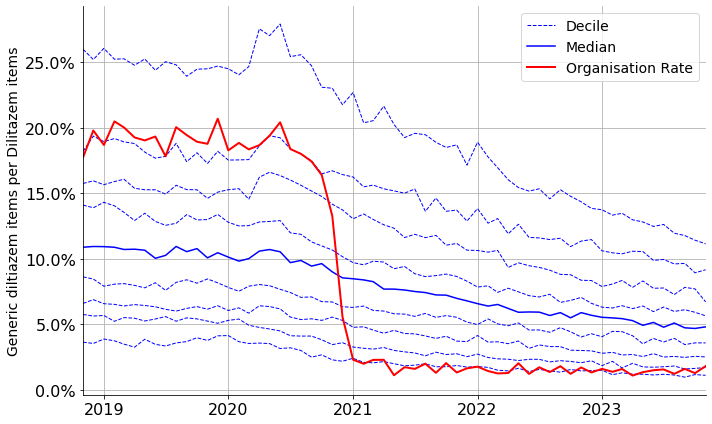

<h2 id=carbon_salbutamol><a href=https://openprescribing.net/measure/carbon_salbutamol>Environmental impact of inhalers - average carbon footprint per salbutamol inhaler</a></h2>

<h4><a href=https://openprescribing.net/measure/carbon_salbutamol/sicbl/15C>NHS BRISTOL, NORTH SOMERSET AND SOUTH GLOUCESTERSHIRE</a></h4>

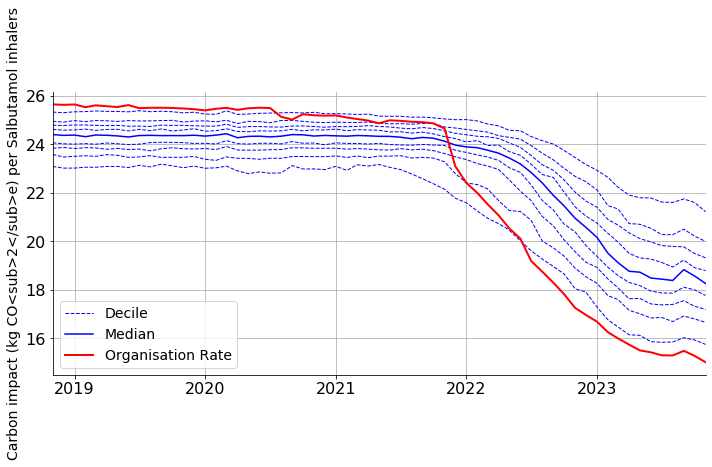

<h4><a href=https://openprescribing.net/measure/carbon_salbutamol/sicbl/05G>NHS NORTH STAFFORDSHIRE</a></h4>

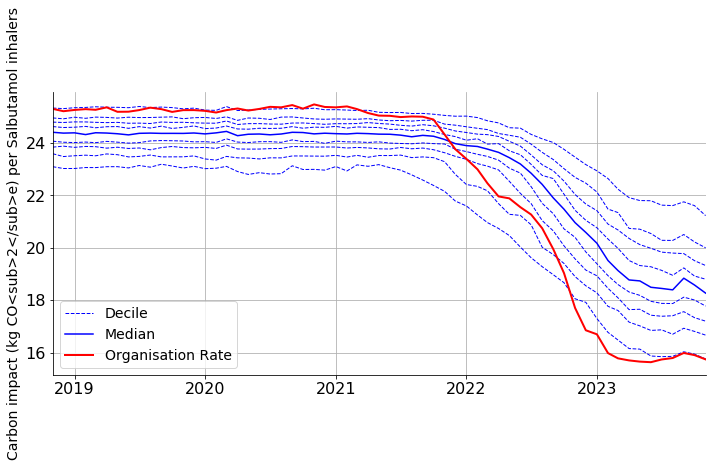

<h4><a href=https://openprescribing.net/measure/carbon_salbutamol/sicbl/D4U1Y>NHS FRIMLEY</a></h4>

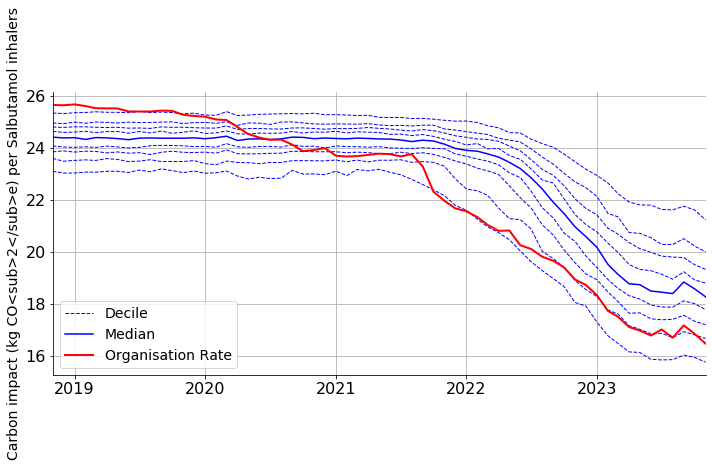

<h4><a href=https://openprescribing.net/measure/carbon_salbutamol/sicbl/06N>NHS HERTS VALLEYS</a></h4>

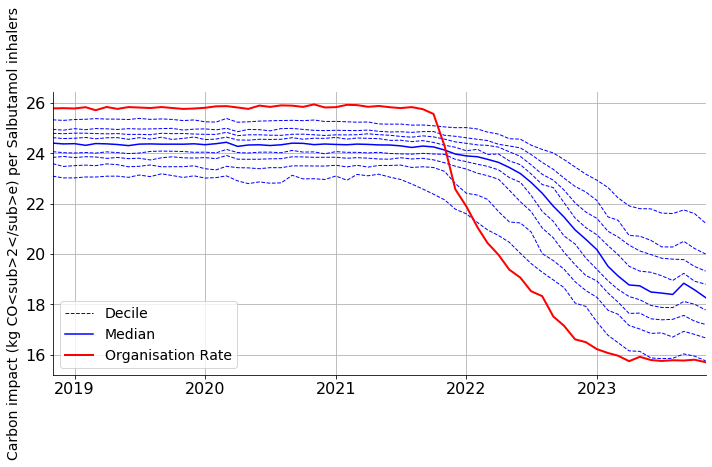

<h4><a href=https://openprescribing.net/measure/carbon_salbutamol/sicbl/27D>NHS CHESHIRE</a></h4>

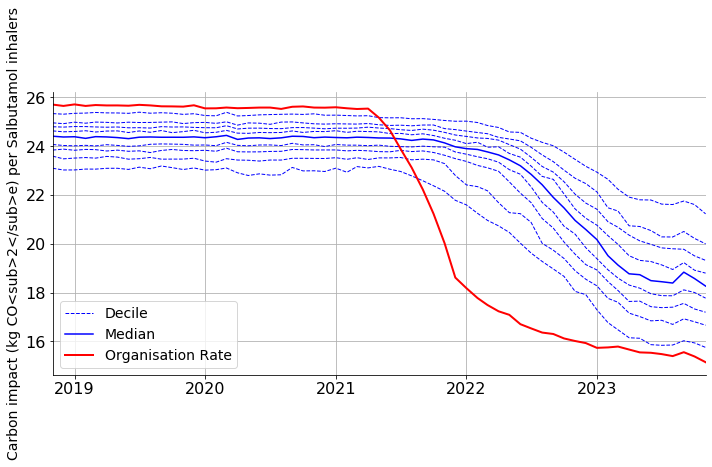

<h2 id=environmental_inhalers><a href=https://openprescribing.net/measure/environmental_inhalers>Environmental impact of inhalers - prescribing of non-salbutamol Metered Dose Inhalers (MDIs)</a></h2>

<h4><a href=https://openprescribing.net/measure/environmental_inhalers/sicbl/26A>NHS NORFOLK AND WAVENEY</a></h4>

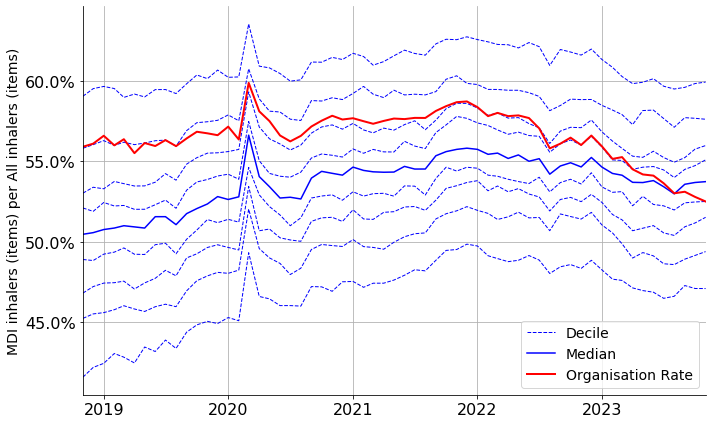

<h4><a href=https://openprescribing.net/measure/environmental_inhalers/sicbl/11N>NHS KERNOW</a></h4>

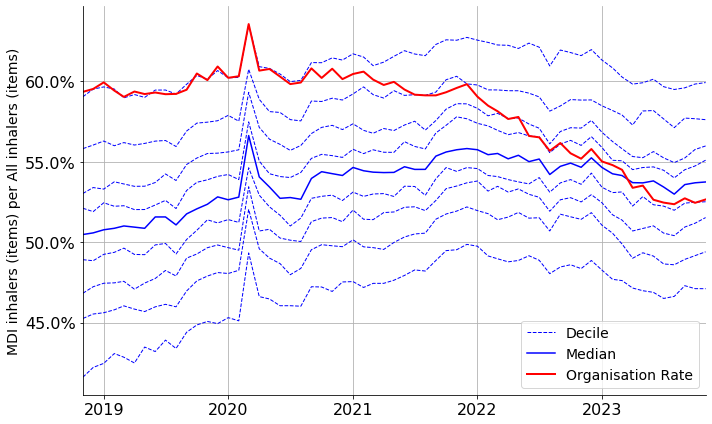

<h2 id=icsdose><a href=https://openprescribing.net/measure/icsdose>High dose inhaled corticosteroids</a></h2>

<h4><a href=https://openprescribing.net/measure/icsdose/sicbl/00P>NHS SUNDERLAND</a></h4>

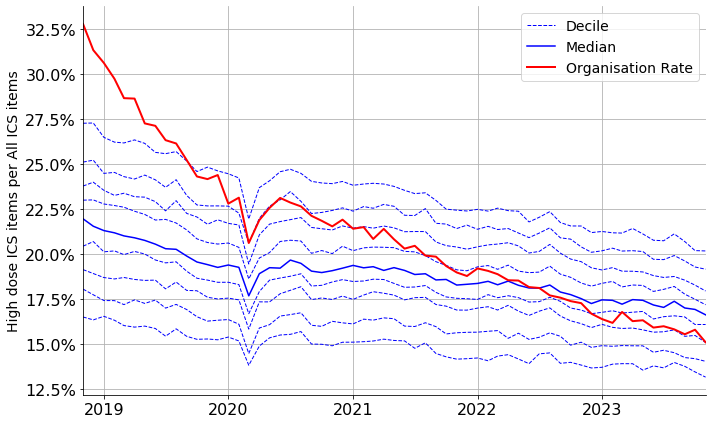

<h2 id=opioidspercent><a href=https://openprescribing.net/measure/opioidspercent>High dose opioid items as percentage regular opioids</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=opioidper1000><a href=https://openprescribing.net/measure/opioidper1000>High dose opioids per 1000 patients</a></h2>

<h4><a href=https://openprescribing.net/measure/opioidper1000/sicbl/99C>NHS NORTH TYNESIDE</a></h4>

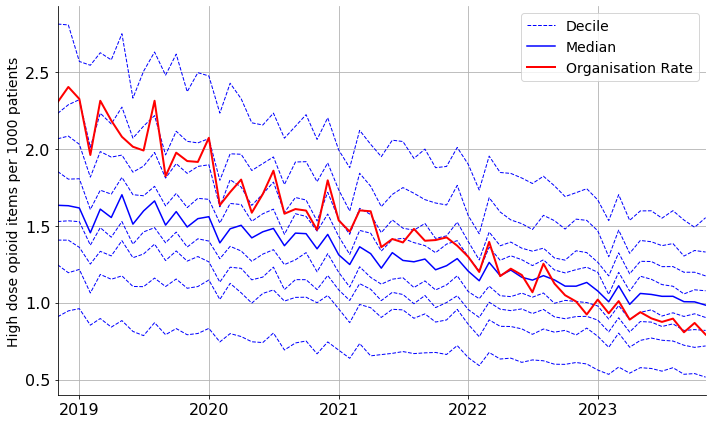

<h4><a href=https://openprescribing.net/measure/opioidper1000/sicbl/00P>NHS SUNDERLAND</a></h4>

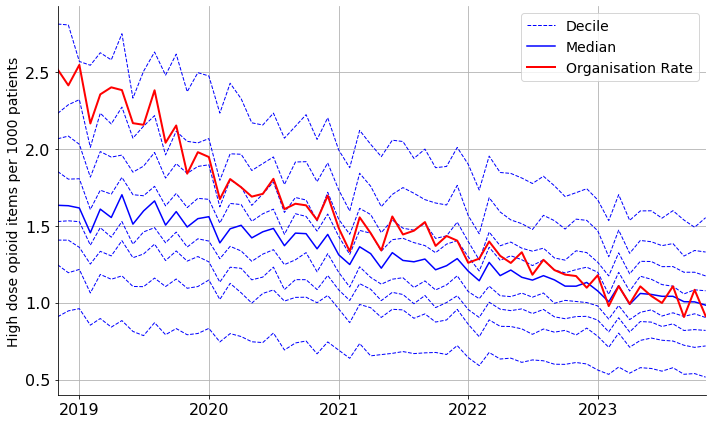

<h2 id=sildenafil><a href=https://openprescribing.net/measure/sildenafil>High-cost drugs for erectile dysfunction</a></h2>

<h4><a href=https://openprescribing.net/measure/sildenafil/sicbl/02A>NHS TRAFFORD</a></h4>

<ipython-input-21-2f36c4ab574a>:108: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


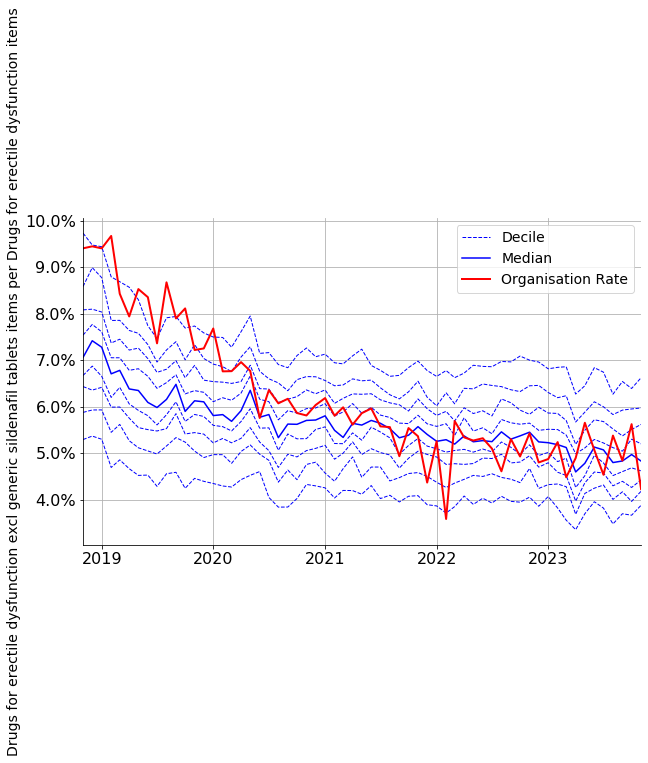

<h4><a href=https://openprescribing.net/measure/sildenafil/sicbl/02X>NHS DONCASTER</a></h4>

<ipython-input-21-2f36c4ab574a>:108: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


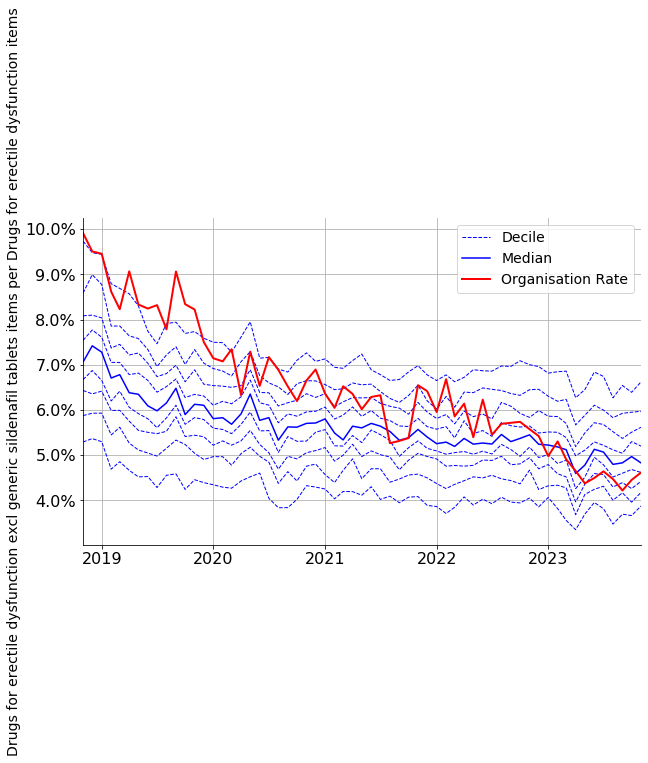

<h4><a href=https://openprescribing.net/measure/sildenafil/sicbl/00T>NHS BOLTON</a></h4>

<ipython-input-21-2f36c4ab574a>:108: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


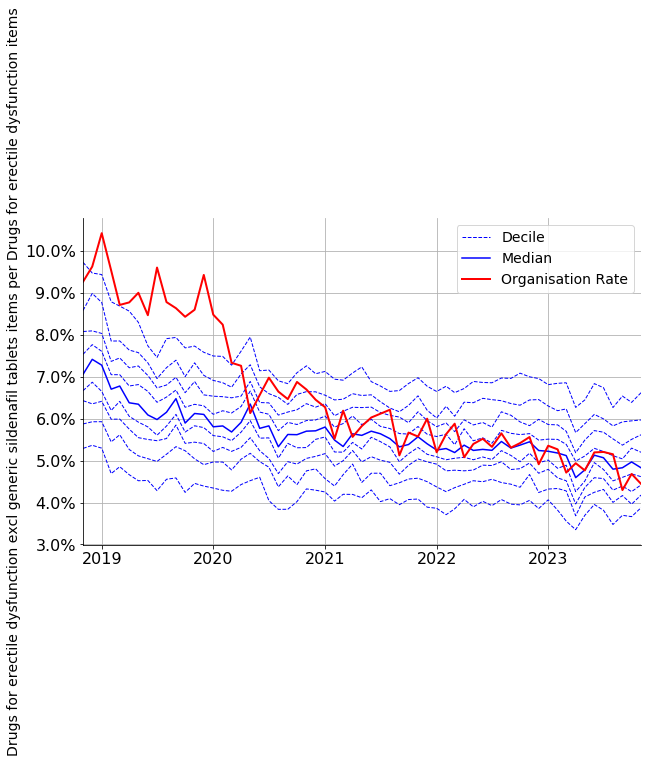

<h4><a href=https://openprescribing.net/measure/sildenafil/sicbl/05D>NHS EAST STAFFORDSHIRE</a></h4>

<ipython-input-21-2f36c4ab574a>:108: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


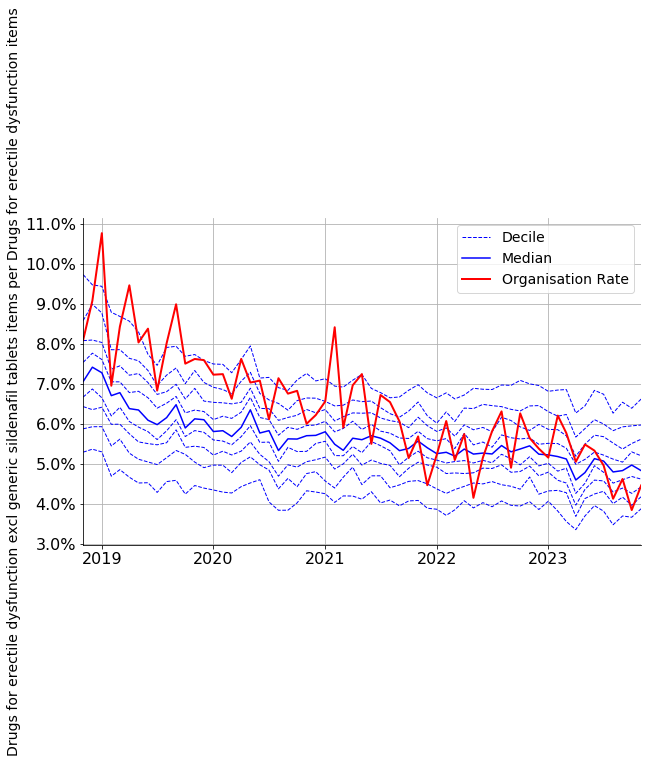

<h4><a href=https://openprescribing.net/measure/sildenafil/sicbl/03N>NHS SHEFFIELD</a></h4>

<ipython-input-21-2f36c4ab574a>:108: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


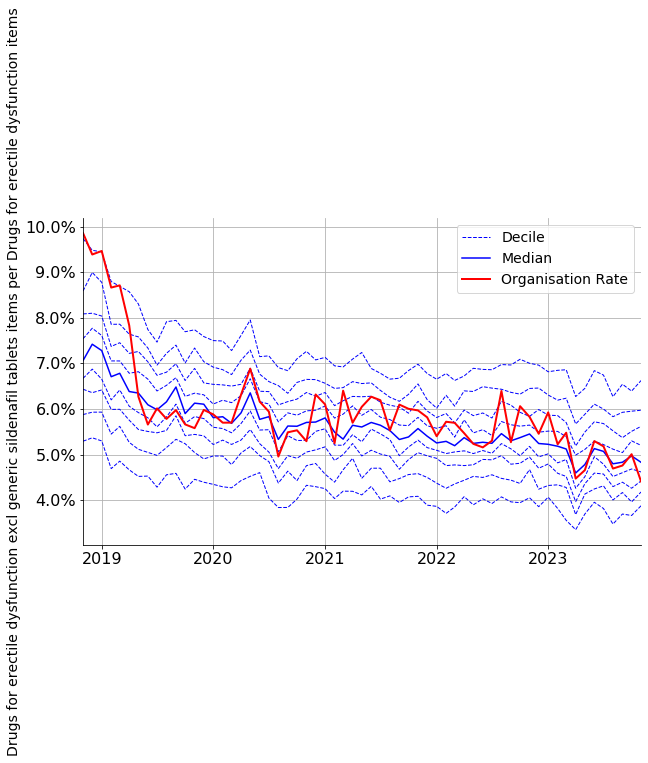

<h2 id=ppidose><a href=https://openprescribing.net/measure/ppidose>Higher dose Proton Pump Inhibitors (PPIs)</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=lpbathshoweremollients><a href=https://openprescribing.net/measure/lpbathshoweremollients>Items which should not routinely be prescribed in primary care  - bath and shower emollients</a></h2>

<h4><a href=https://openprescribing.net/measure/lpbathshoweremollients/sicbl/01G>NHS SALFORD</a></h4>

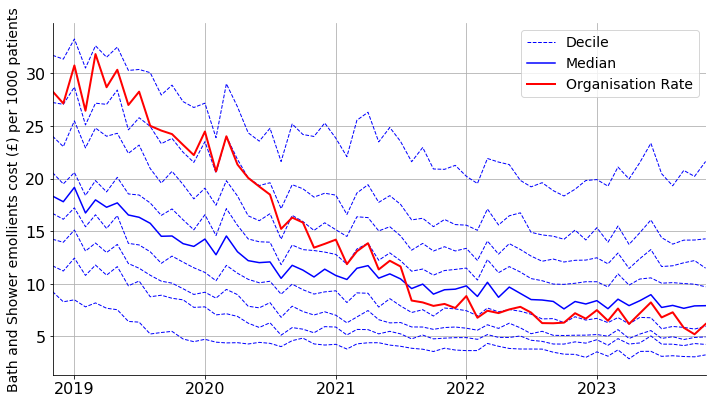

<h4><a href=https://openprescribing.net/measure/lpbathshoweremollients/sicbl/02P>NHS BARNSLEY</a></h4>

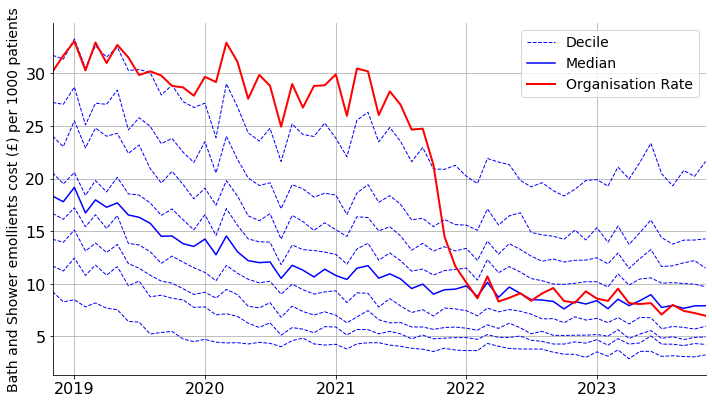

<h4><a href=https://openprescribing.net/measure/lpbathshoweremollients/sicbl/00T>NHS BOLTON</a></h4>

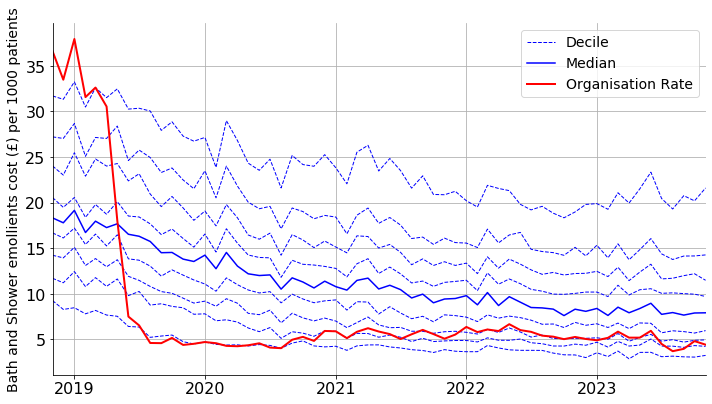

<h2 id=lpaliskiren><a href=https://openprescribing.net/measure/lpaliskiren>Items which should not routinely be prescribed in primary care - aliskiren</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=lpzomnibus><a href=https://openprescribing.net/measure/lpzomnibus>Items which should not routinely be prescribed in primary care - all items</a></h2>

<h4><a href=https://openprescribing.net/measure/lpzomnibus/sicbl/02P>NHS BARNSLEY</a></h4>

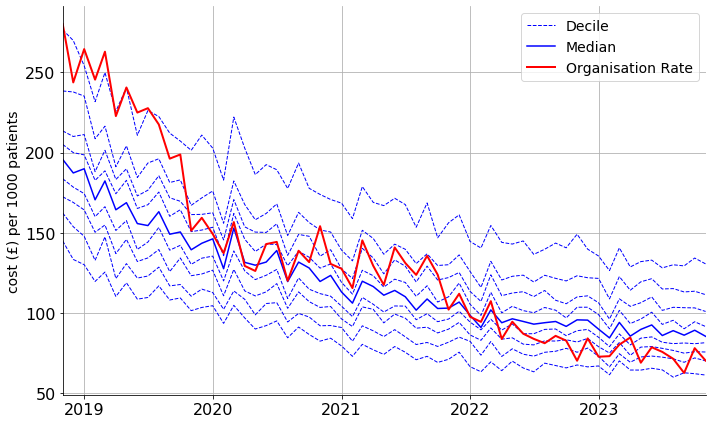

<h4><a href=https://openprescribing.net/measure/lpzomnibus/sicbl/99E>NHS BASILDON AND BRENTWOOD</a></h4>

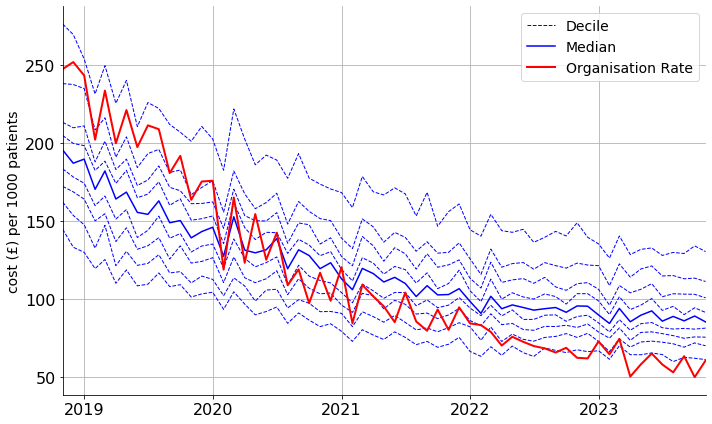

<h4><a href=https://openprescribing.net/measure/lpzomnibus/sicbl/00Y>NHS OLDHAM</a></h4>

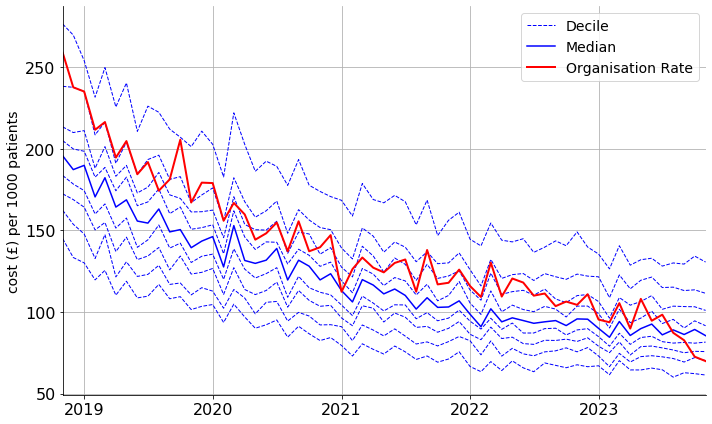

<h2 id=lpamiodarone><a href=https://openprescribing.net/measure/lpamiodarone>Items which should not routinely be prescribed in primary care - amiodarone</a></h2>

<h4><a href=https://openprescribing.net/measure/lpamiodarone/sicbl/99G>NHS SOUTHEND</a></h4>

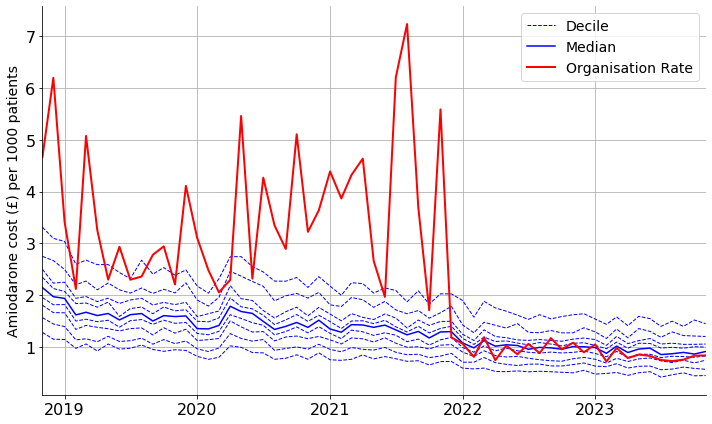

<h4><a href=https://openprescribing.net/measure/lpamiodarone/sicbl/01Y>NHS TAMESIDE AND GLOSSOP</a></h4>

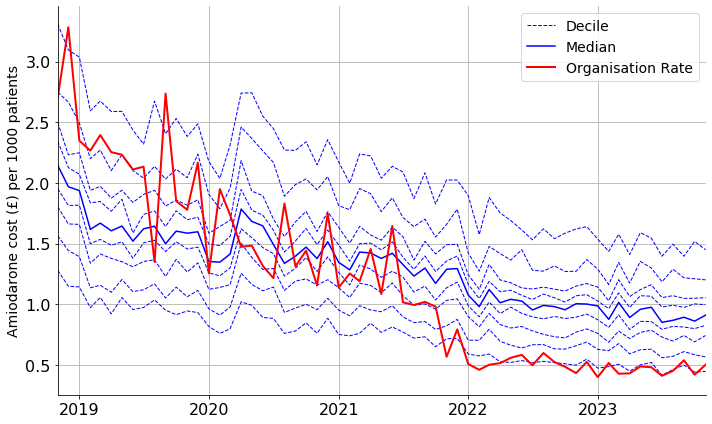

<h2 id=lpcoprox><a href=https://openprescribing.net/measure/lpcoprox>Items which should not routinely be prescribed in primary care - co-proxamol</a></h2>

<h4><a href=https://openprescribing.net/measure/lpcoprox/sicbl/05V>NHS STAFFORD AND SURROUNDS</a></h4>

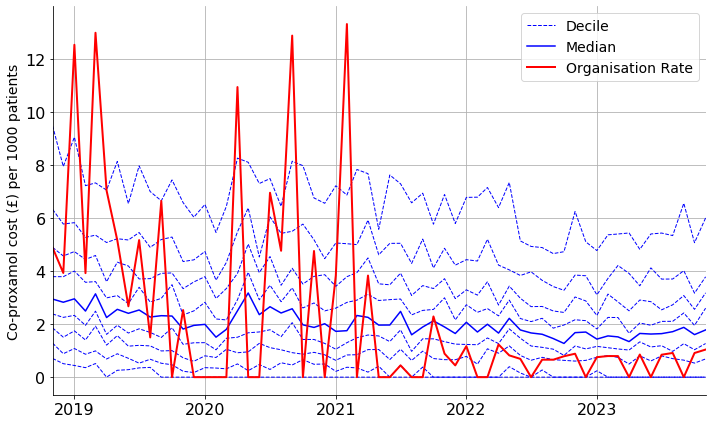

<h2 id=lpdosulepin><a href=https://openprescribing.net/measure/lpdosulepin>Items which should not routinely be prescribed in primary care - dosulepin</a></h2>

<h4><a href=https://openprescribing.net/measure/lpdosulepin/sicbl/01A>NHS EAST LANCASHIRE</a></h4>

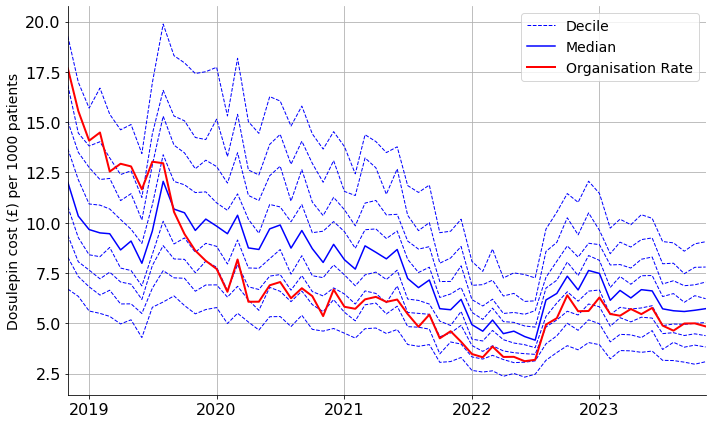

<h2 id=lpdoxazosin><a href=https://openprescribing.net/measure/lpdoxazosin>Items which should not routinely be prescribed in primary care - doxazosin modified release</a></h2>

<h4><a href=https://openprescribing.net/measure/lpdoxazosin/sicbl/06L>NHS IPSWICH AND EAST SUFFOLK</a></h4>

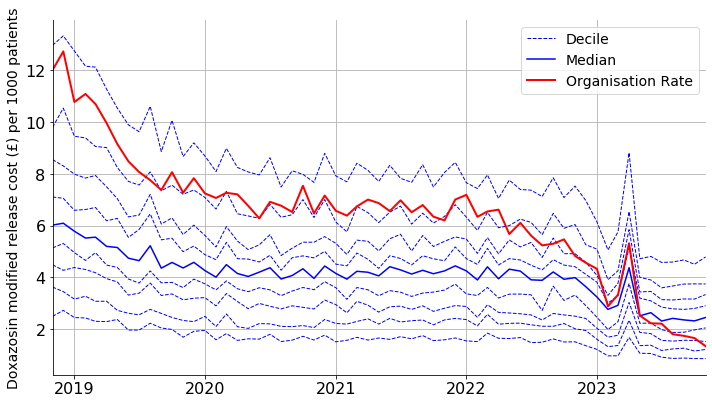

<h4><a href=https://openprescribing.net/measure/lpdoxazosin/sicbl/00Y>NHS OLDHAM</a></h4>

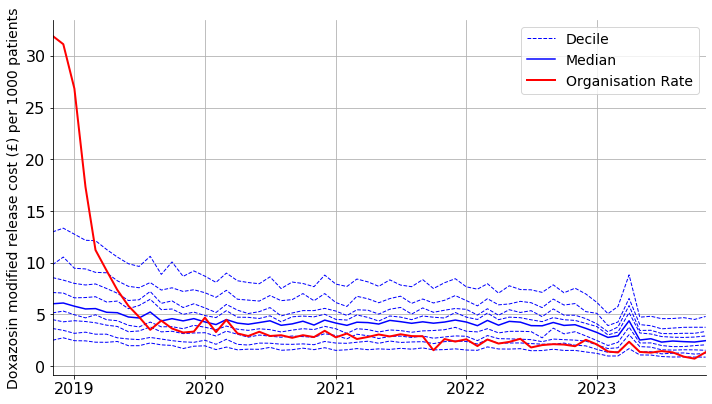

<h2 id=lpdronedarone><a href=https://openprescribing.net/measure/lpdronedarone>Items which should not routinely be prescribed in primary care - dronedarone</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=lpglucosamine><a href=https://openprescribing.net/measure/lpglucosamine>Items which should not routinely be prescribed in primary care - glucosamine and chondroitin</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=lpherbal><a href=https://openprescribing.net/measure/lpherbal>Items which should not routinely be prescribed in primary care - herbal medicines</a></h2>

<h4><a href=https://openprescribing.net/measure/lpherbal/sicbl/03H>NHS NORTH EAST LINCOLNSHIRE</a></h4>

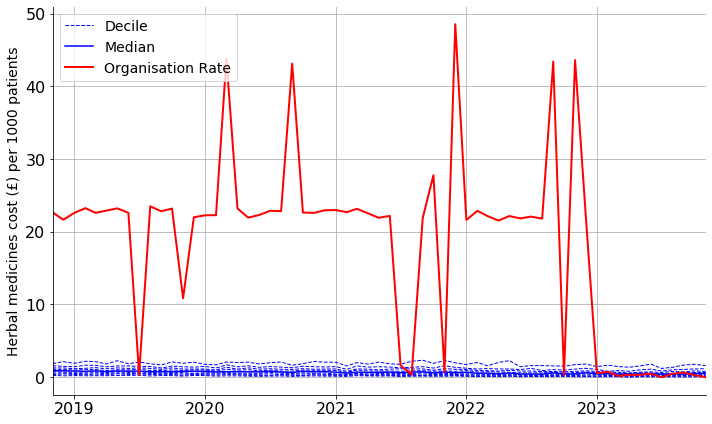

<h4><a href=https://openprescribing.net/measure/lpherbal/sicbl/02T>NHS CALDERDALE</a></h4>

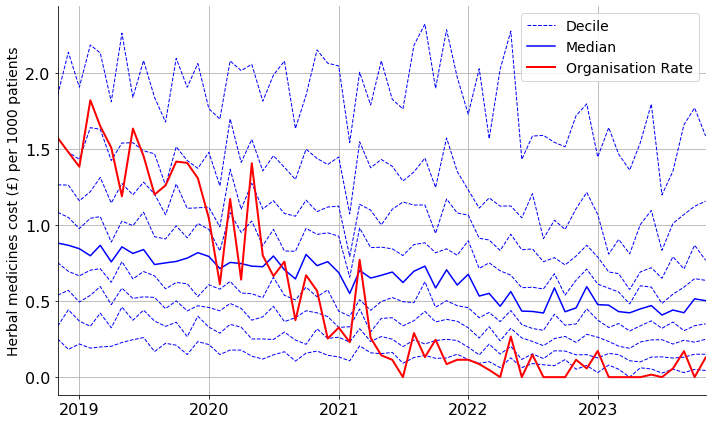

<h4><a href=https://openprescribing.net/measure/lpherbal/sicbl/15F>NHS LEEDS</a></h4>

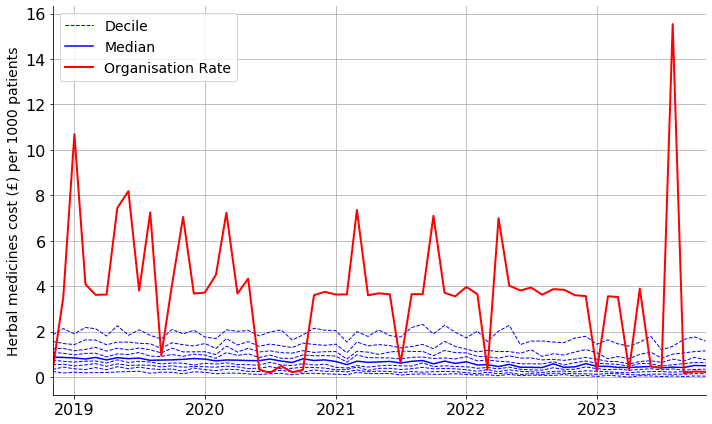

<h4><a href=https://openprescribing.net/measure/lpherbal/sicbl/01F>NHS HALTON</a></h4>

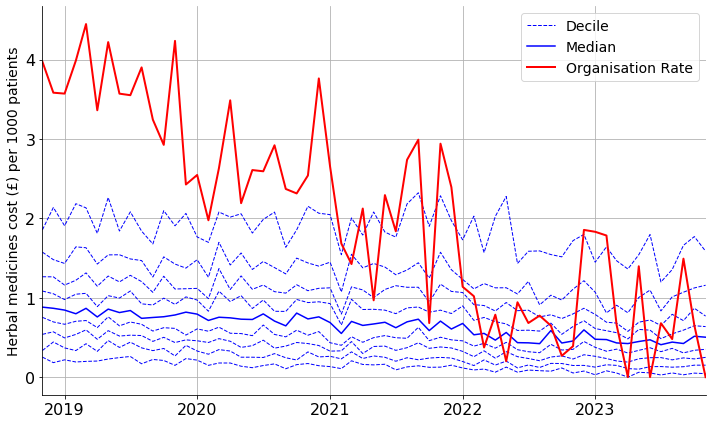

<h2 id=lphomeopathy><a href=https://openprescribing.net/measure/lphomeopathy>Items which should not routinely be prescribed in primary care - homeopathy</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=lpfentanylir><a href=https://openprescribing.net/measure/lpfentanylir>Items which should not routinely be prescribed in primary care - immediate release fentanyl</a></h2>

<h4><a href=https://openprescribing.net/measure/lpfentanylir/sicbl/99C>NHS NORTH TYNESIDE</a></h4>

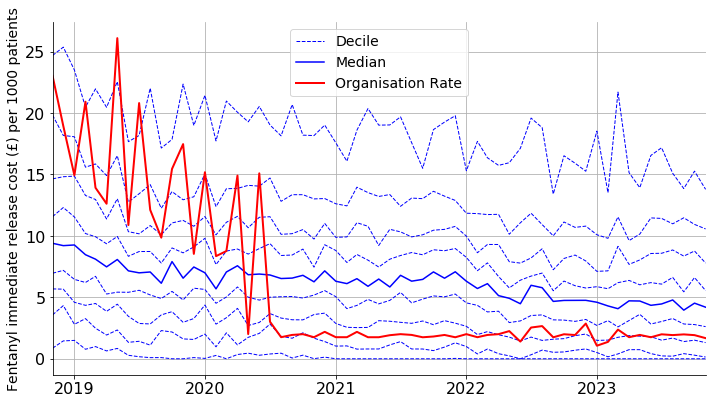

<h2 id=lpneedles><a href=https://openprescribing.net/measure/lpneedles>Items which should not routinely be prescribed in primary care - insulin pen needles costing ≥£5 per 100 needles</a></h2>

<h4><a href=https://openprescribing.net/measure/lpneedles/sicbl/07G>NHS THURROCK</a></h4>

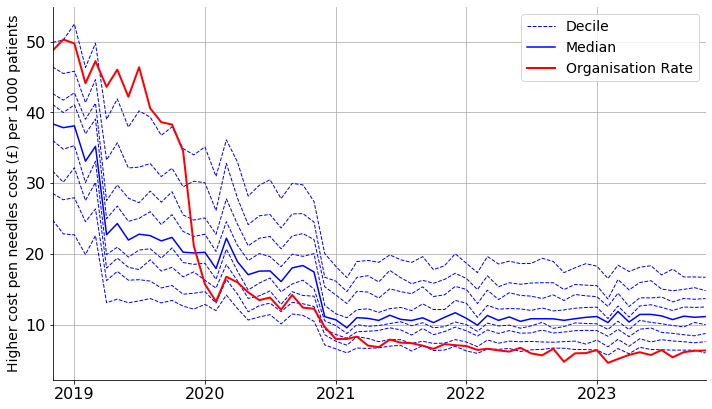

<h4><a href=https://openprescribing.net/measure/lpneedles/sicbl/05D>NHS EAST STAFFORDSHIRE</a></h4>

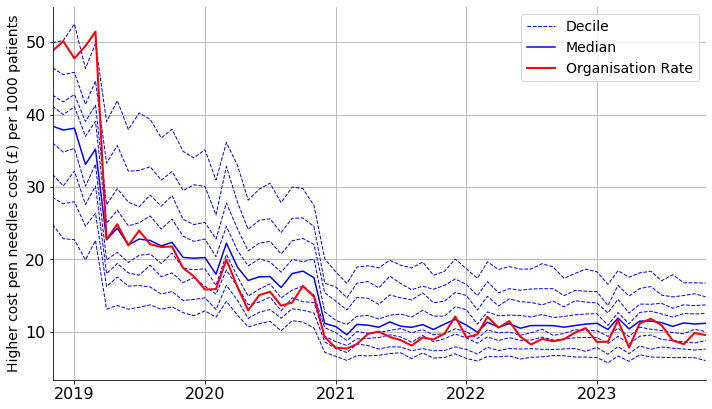

<h4><a href=https://openprescribing.net/measure/lpneedles/sicbl/02P>NHS BARNSLEY</a></h4>

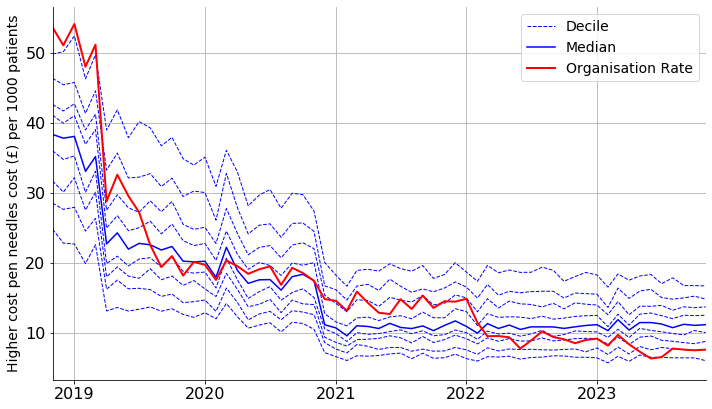

<h4><a href=https://openprescribing.net/measure/lpneedles/sicbl/01H>NHS NORTH CUMBRIA</a></h4>

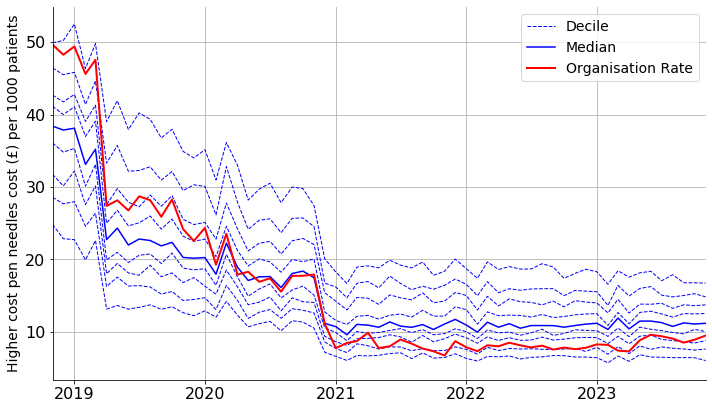

<h2 id=lplidocaine><a href=https://openprescribing.net/measure/lplidocaine>Items which should not routinely be prescribed in primary care - lidocaine plasters</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=lpliothyronine><a href=https://openprescribing.net/measure/lpliothyronine>Items which should not routinely be prescribed in primary care - liothyronine (including Armour Thyroid and liothyronine combination products)</a></h2>

<h4><a href=https://openprescribing.net/measure/lpliothyronine/sicbl/99E>NHS BASILDON AND BRENTWOOD</a></h4>

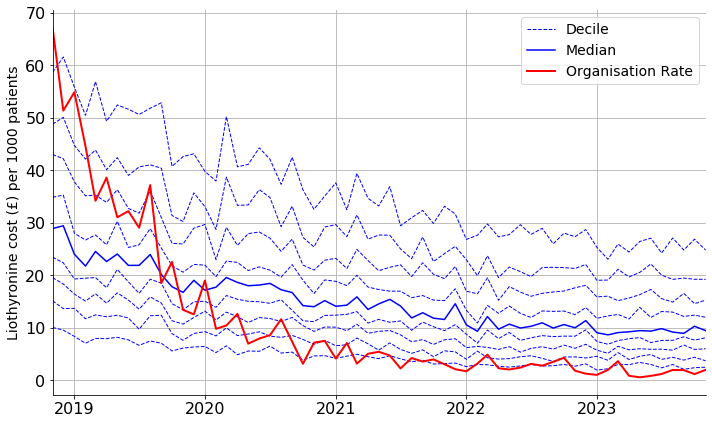

<h2 id=lplutein><a href=https://openprescribing.net/measure/lplutein>Items which should not routinely be prescribed in primary care - lutein and antioxidants</a></h2>

<h4><a href=https://openprescribing.net/measure/lplutein/sicbl/15N>NHS DEVON</a></h4>

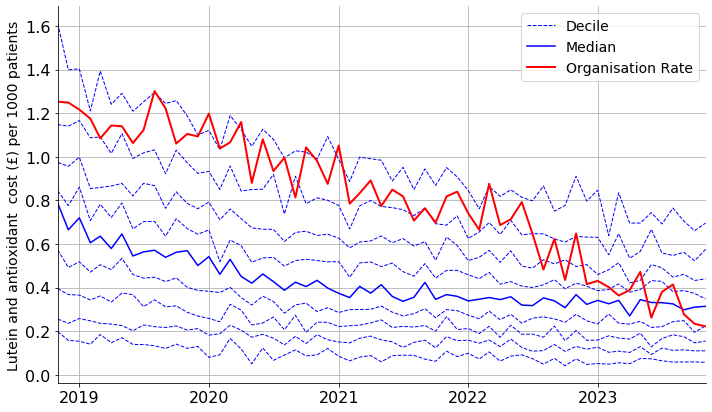

<h2 id=lpminocycline><a href=https://openprescribing.net/measure/lpminocycline>Items which should not routinely be prescribed in primary care - minocycline</a></h2>

<h4><a href=https://openprescribing.net/measure/lpminocycline/sicbl/02A>NHS TRAFFORD</a></h4>

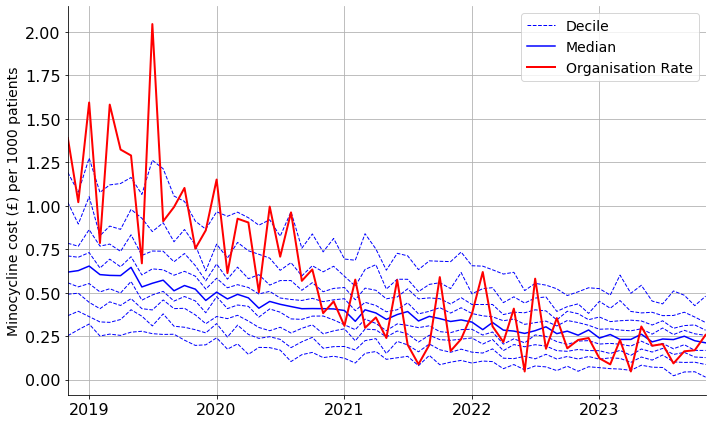

<h4><a href=https://openprescribing.net/measure/lpminocycline/sicbl/02X>NHS DONCASTER</a></h4>

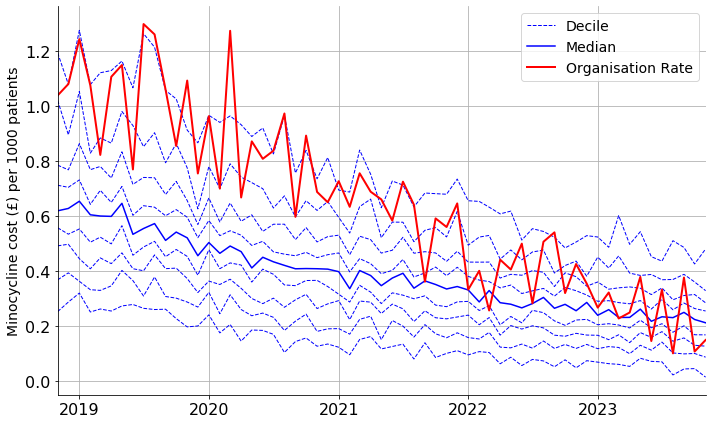

<h2 id=lpomega3><a href=https://openprescribing.net/measure/lpomega3>Items which should not routinely be prescribed in primary care - omega-3 fatty acid compounds (excluding icosapent ethyl [Vazkepa®])</a></h2>

<h4><a href=https://openprescribing.net/measure/lpomega3/sicbl/99E>NHS BASILDON AND BRENTWOOD</a></h4>

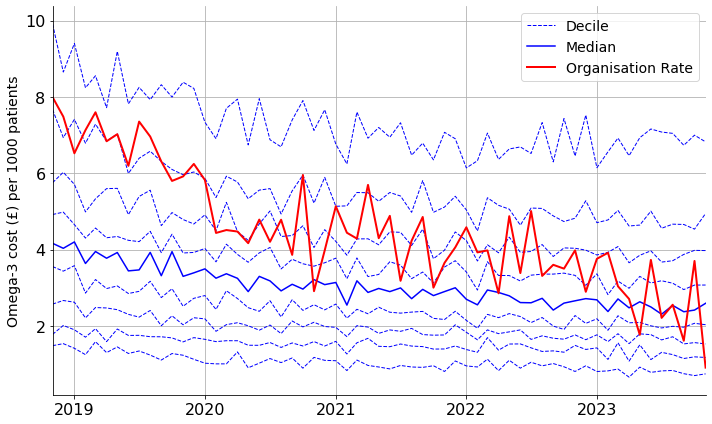

<h4><a href=https://openprescribing.net/measure/lpomega3/sicbl/06T>NHS NORTH EAST ESSEX</a></h4>

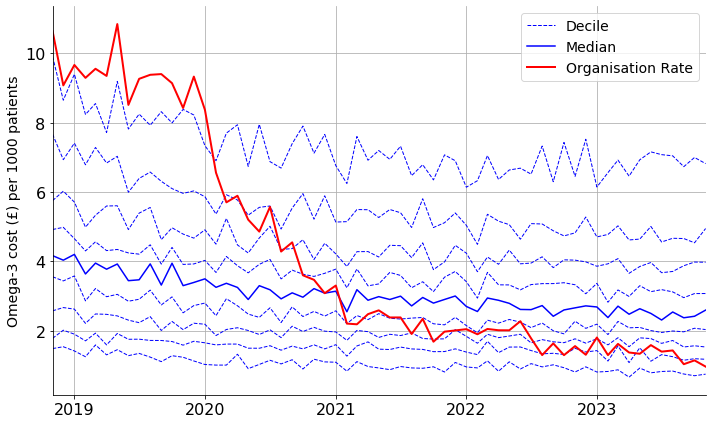

<h4><a href=https://openprescribing.net/measure/lpomega3/sicbl/07G>NHS THURROCK</a></h4>

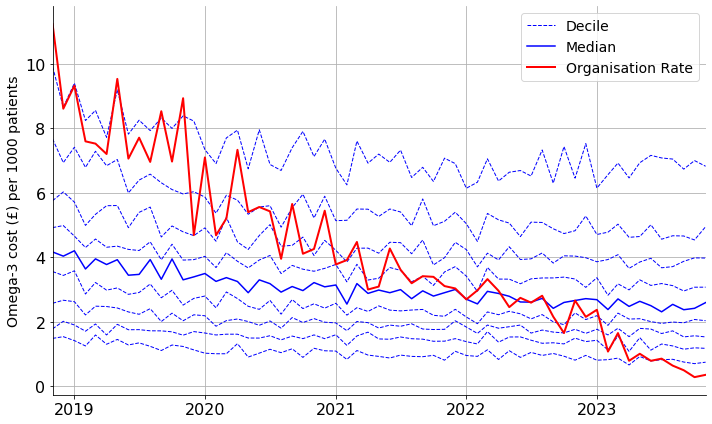

<h2 id=lpoxycodone><a href=https://openprescribing.net/measure/lpoxycodone>Items which should not routinely be prescribed in primary care - oxycodone and naloxone combination product</a></h2>

<h4><a href=https://openprescribing.net/measure/lpoxycodone/sicbl/99E>NHS BASILDON AND BRENTWOOD</a></h4>

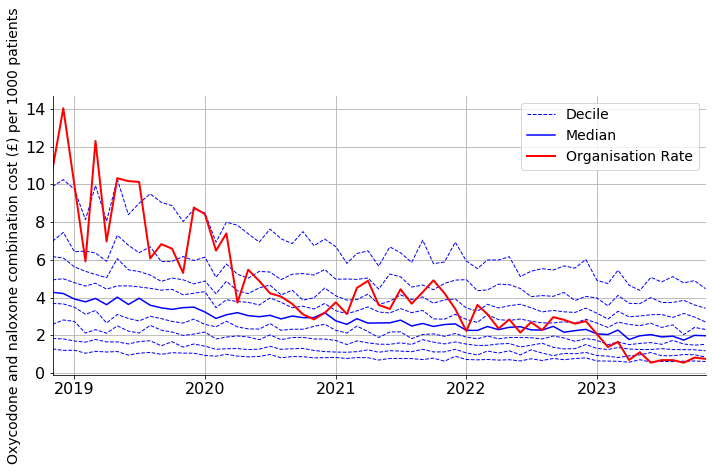

<h2 id=lptramadolpara><a href=https://openprescribing.net/measure/lptramadolpara>Items which should not routinely be prescribed in primary care - paracetamol and tramadol combination</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=lpperindopril><a href=https://openprescribing.net/measure/lpperindopril>Items which should not routinely be prescribed in primary care - perindopril arginine</a></h2>

<h4><a href=https://openprescribing.net/measure/lpperindopril/sicbl/02P>NHS BARNSLEY</a></h4>

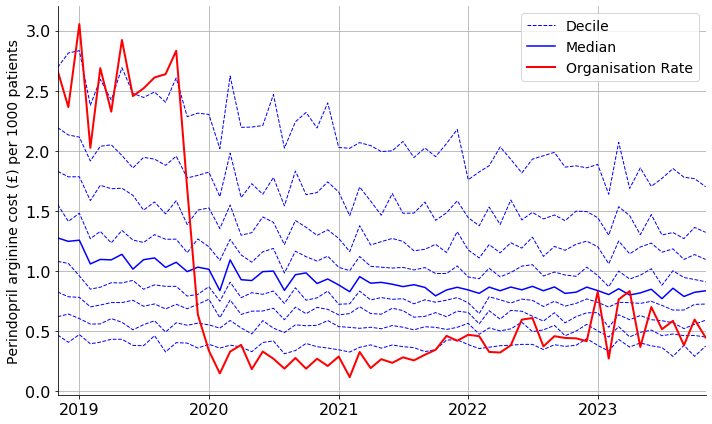

<h2 id=lprubefacients><a href=https://openprescribing.net/measure/lprubefacients>Items which should not routinely be prescribed in primary care - rubefacients, benzydamine, mucopolysaccharide and cooling products</a></h2>

<h4><a href=https://openprescribing.net/measure/lprubefacients/sicbl/02P>NHS BARNSLEY</a></h4>

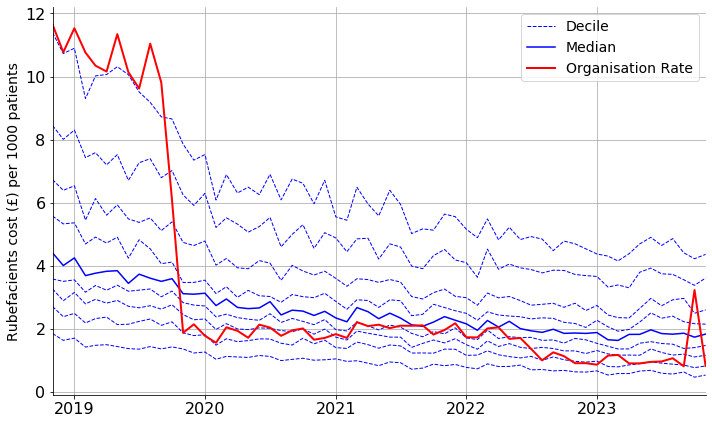

<h4><a href=https://openprescribing.net/measure/lprubefacients/sicbl/01V>NHS SOUTHPORT AND FORMBY</a></h4>

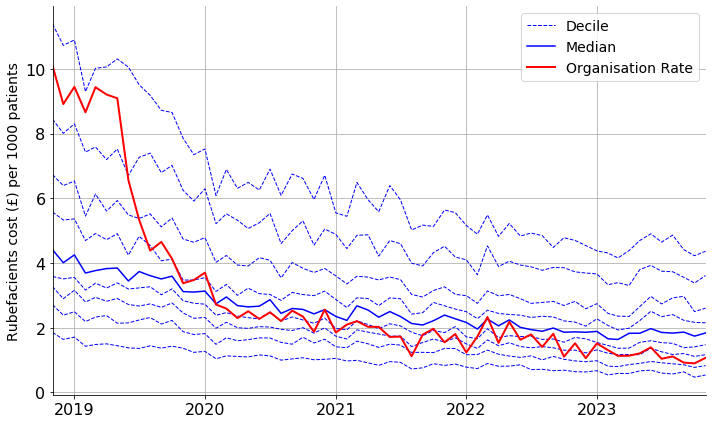

<h2 id=lpsilkgarments><a href=https://openprescribing.net/measure/lpsilkgarments>Items which should not routinely be prescribed in primary care - silk garments</a></h2>

<h4><a href=https://openprescribing.net/measure/lpsilkgarments/sicbl/01V>NHS SOUTHPORT AND FORMBY</a></h4>

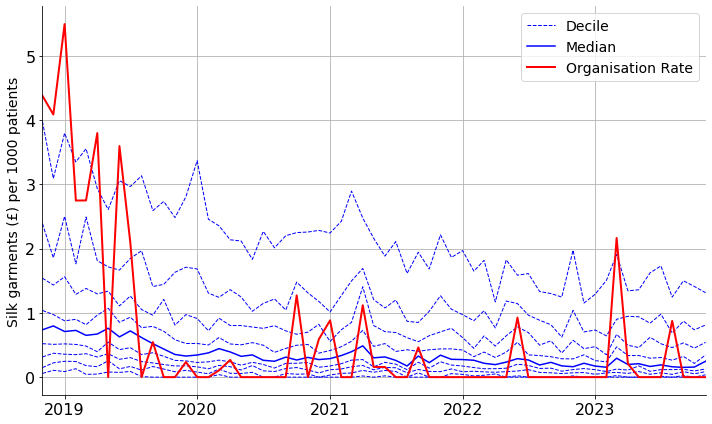

<h4><a href=https://openprescribing.net/measure/lpsilkgarments/sicbl/01F>NHS HALTON</a></h4>

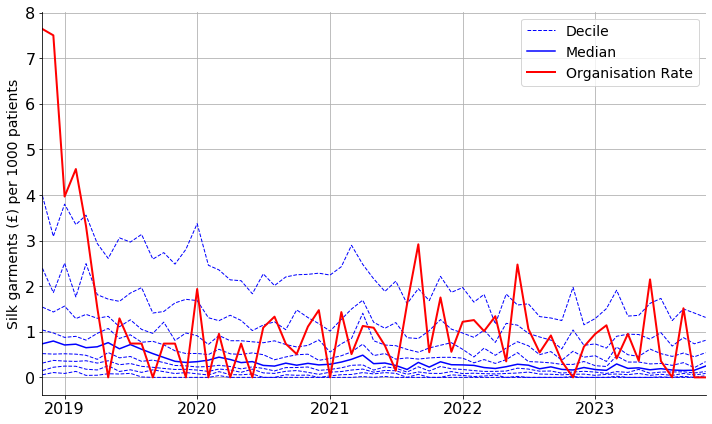

<h2 id=lptravelvacs><a href=https://openprescribing.net/measure/lptravelvacs>Items which should not routinely be prescribed in primary care - travel vaccines</a></h2>

<h4><a href=https://openprescribing.net/measure/lptravelvacs/sicbl/06L>NHS IPSWICH AND EAST SUFFOLK</a></h4>

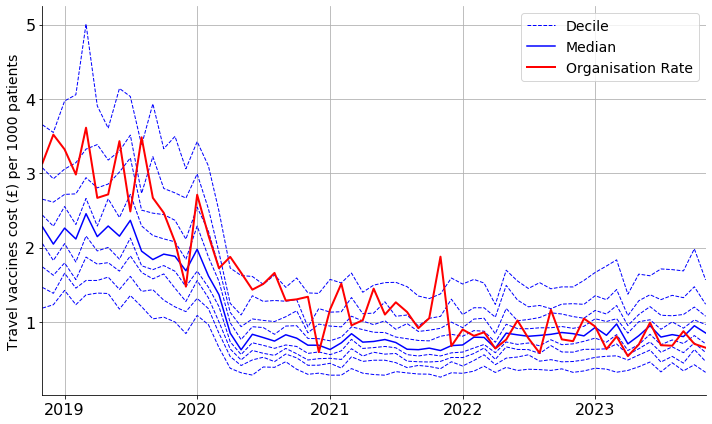

<h4><a href=https://openprescribing.net/measure/lptravelvacs/sicbl/72Q>NHS SOUTH EAST LONDON</a></h4>

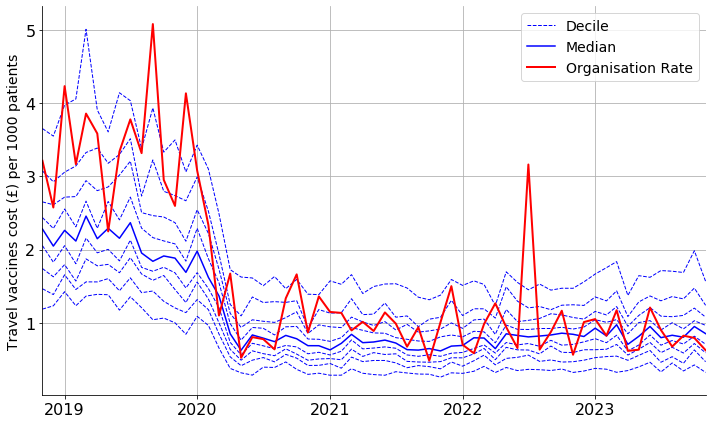

<h4><a href=https://openprescribing.net/measure/lptravelvacs/sicbl/05W>NHS STOKE ON TRENT</a></h4>

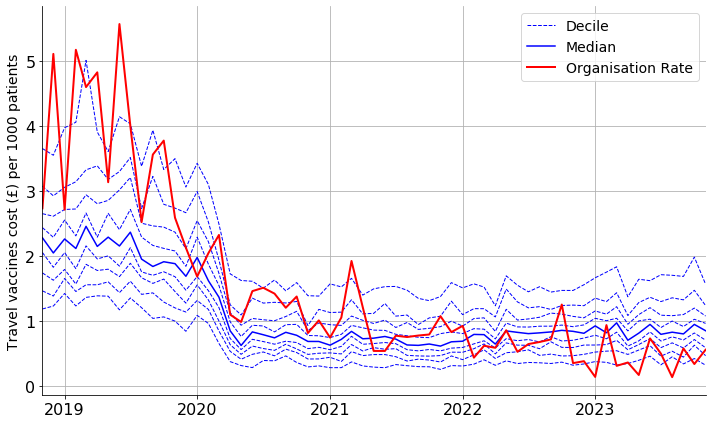

<h2 id=lptrimipramine><a href=https://openprescribing.net/measure/lptrimipramine>Items which should not routinely be prescribed in primary care - trimipramine</a></h2>

<h4><a href=https://openprescribing.net/measure/lptrimipramine/sicbl/00Y>NHS OLDHAM</a></h4>

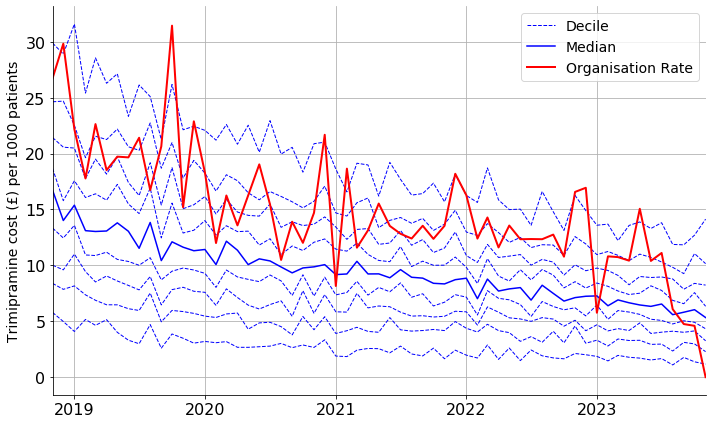

<h4><a href=https://openprescribing.net/measure/lptrimipramine/sicbl/05G>NHS NORTH STAFFORDSHIRE</a></h4>

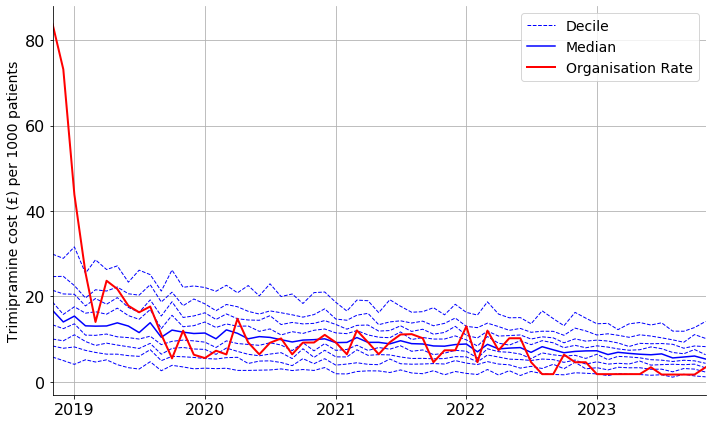

<h4><a href=https://openprescribing.net/measure/lptrimipramine/sicbl/04Y>NHS CANNOCK CHASE</a></h4>

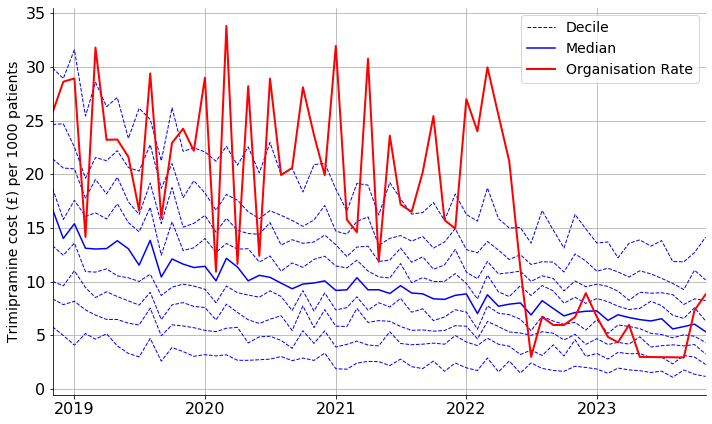

<h4><a href=https://openprescribing.net/measure/lptrimipramine/sicbl/02P>NHS BARNSLEY</a></h4>

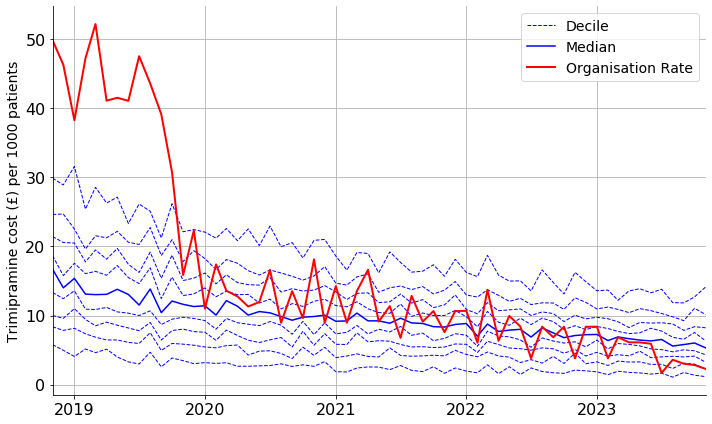

<h4><a href=https://openprescribing.net/measure/lptrimipramine/sicbl/07G>NHS THURROCK</a></h4>

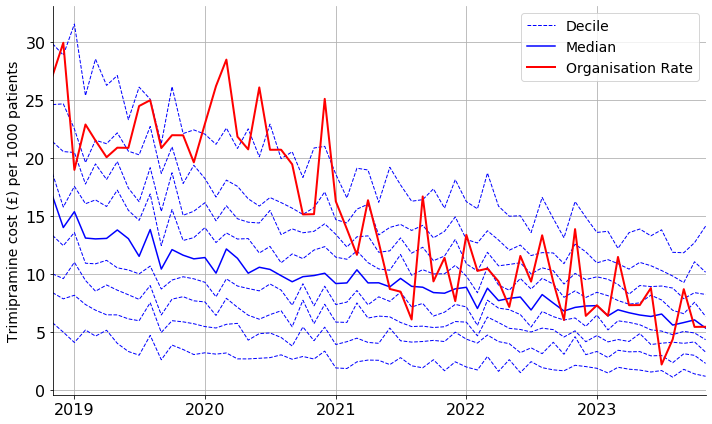

<h2 id=ktt12_diabetes_insulin><a href=https://openprescribing.net/measure/ktt12_diabetes_insulin>Long-acting insulin analogues (KTT12)</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=statinintensity><a href=https://openprescribing.net/measure/statinintensity>Low and medium intensity statins</a></h2>

<h4><a href=https://openprescribing.net/measure/statinintensity/sicbl/11X>NHS SOMERSET</a></h4>

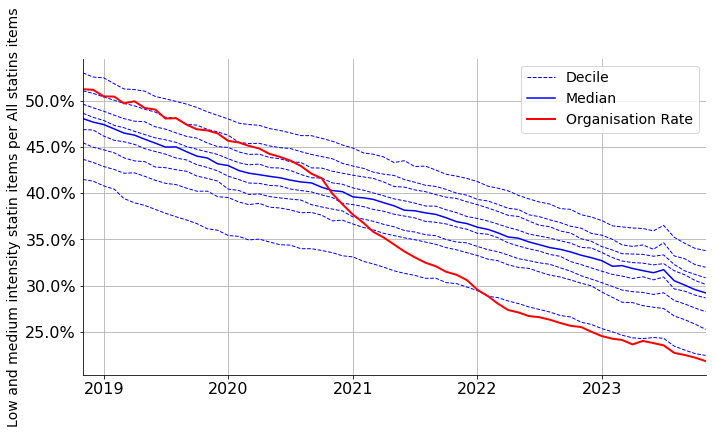

<h4><a href=https://openprescribing.net/measure/statinintensity/sicbl/11M>NHS GLOUCESTERSHIRE</a></h4>

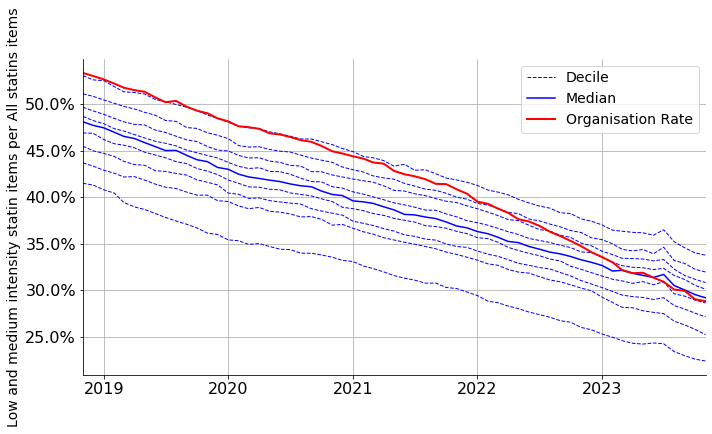

<h2 id=methotrexate><a href=https://openprescribing.net/measure/methotrexate>Methotrexate 10 mg tablets </a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=ktt13_nsaids_ibuprofen><a href=https://openprescribing.net/measure/ktt13_nsaids_ibuprofen>Non-preferred NSAIDs and COX-2 inhibitors (KTT13)</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=semagglutidequantity><a href=https://openprescribing.net/measure/semagglutidequantity>Possible excess quantities of semaglutide</a></h2>

<h4><a href=https://openprescribing.net/measure/semagglutidequantity/sicbl/26A>NHS NORFOLK AND WAVENEY</a></h4>

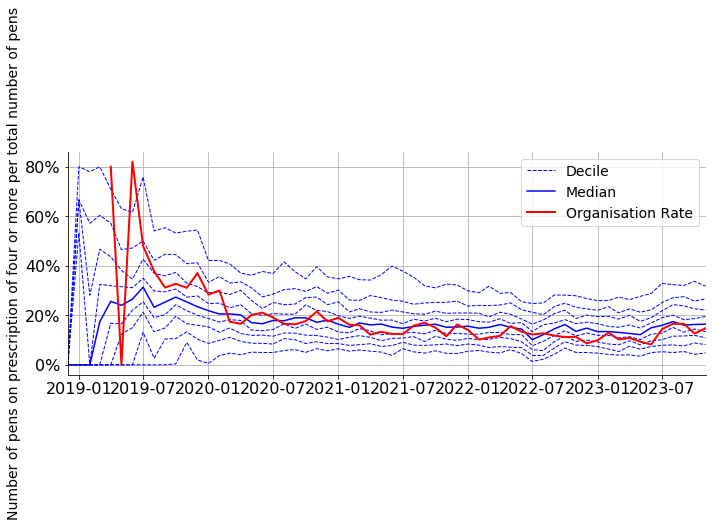

<h2 id=aafpercent><a href=https://openprescribing.net/measure/aafpercent>Prescribing of Amino Acid Formula (AAF) and Extensively Hydrolysed Formula (EHF))</a></h2>

<h4><a href=https://openprescribing.net/measure/aafpercent/sicbl/06Q>NHS MID ESSEX</a></h4>

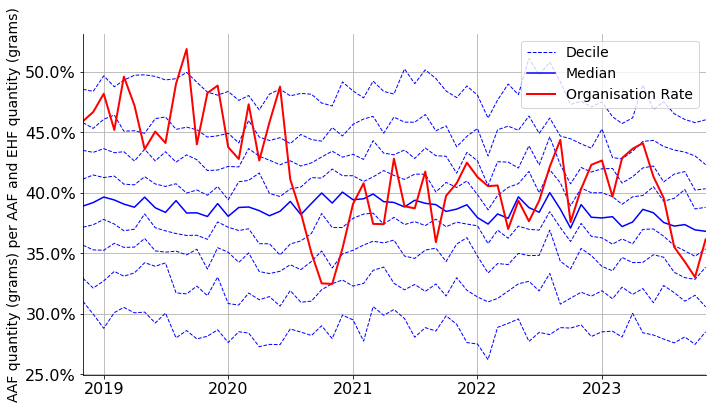

<h4><a href=https://openprescribing.net/measure/aafpercent/sicbl/00L>NHS NORTHUMBERLAND</a></h4>

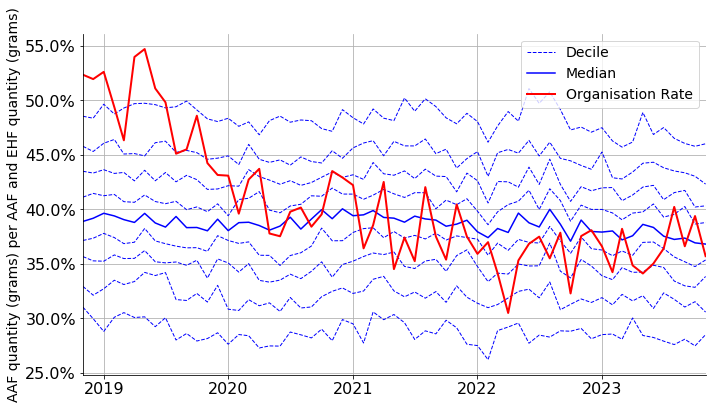

<h2 id=cgm_sensors><a href=https://openprescribing.net/measure/cgm_sensors>Prescribing of continuous glucose monitoring sensors</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=dipyridamole><a href=https://openprescribing.net/measure/dipyridamole>Prescribing of dipyridamole</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=gabapentinoidsddd><a href=https://openprescribing.net/measure/gabapentinoidsddd>Prescribing of gabapentin and pregabalin (DDD)</a></h2>

<h4><a href=https://openprescribing.net/measure/gabapentinoidsddd/sicbl/00L>NHS NORTHUMBERLAND</a></h4>

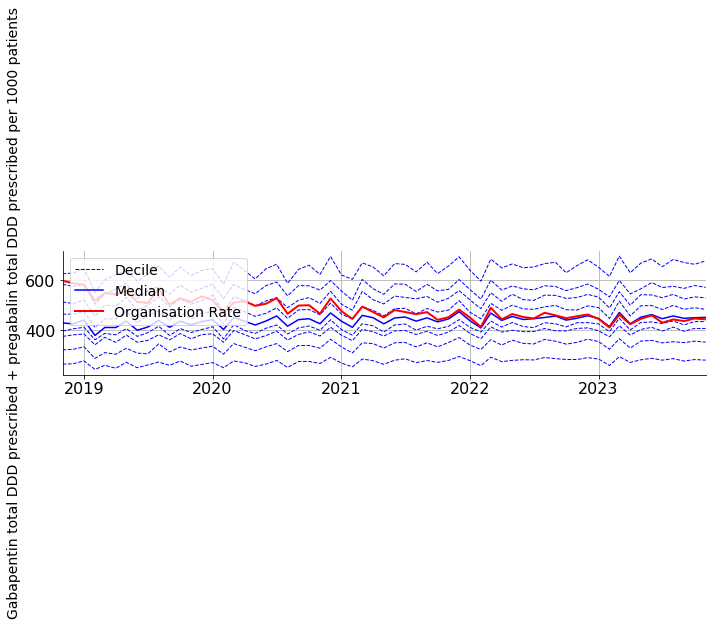

<h2 id=glutenfree><a href=https://openprescribing.net/measure/glutenfree>Prescribing of gluten free products</a></h2>

<h4><a href=https://openprescribing.net/measure/glutenfree/sicbl/05D>NHS EAST STAFFORDSHIRE</a></h4>

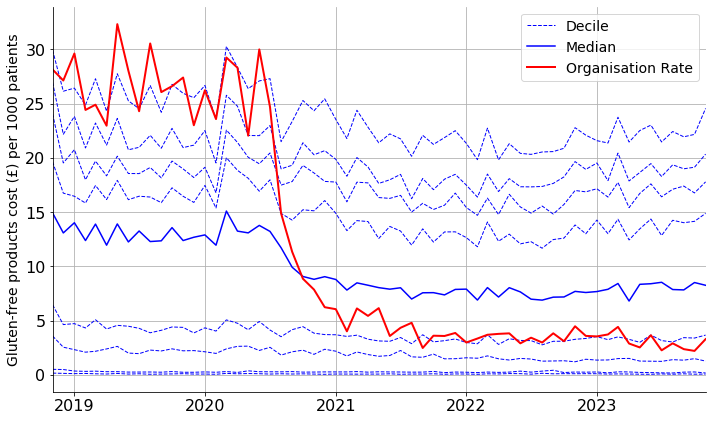

<h4><a href=https://openprescribing.net/measure/glutenfree/sicbl/05Q>NHS SOUTH EAST STAFFORDSHIRE AND SEISDON PENINSULA</a></h4>

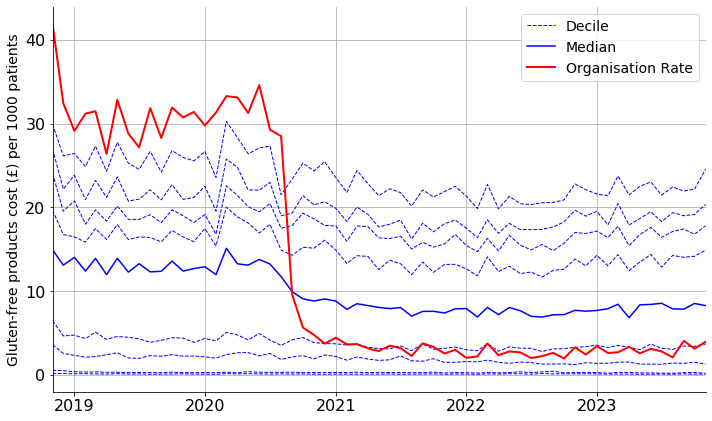

<h4><a href=https://openprescribing.net/measure/glutenfree/sicbl/04Y>NHS CANNOCK CHASE</a></h4>

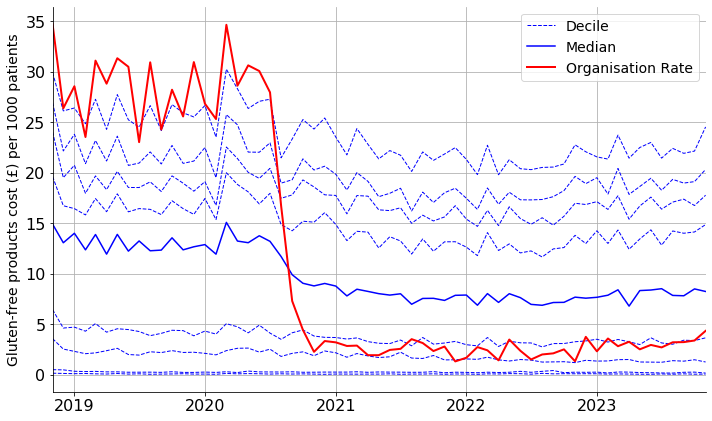

<h4><a href=https://openprescribing.net/measure/glutenfree/sicbl/05V>NHS STAFFORD AND SURROUNDS</a></h4>

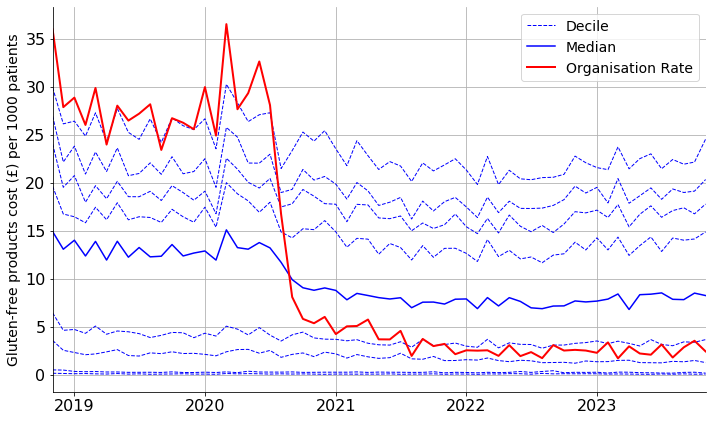

<h2 id=opioidome><a href=https://openprescribing.net/measure/opioidome>Prescribing of opioids (total oral morphine equivalence)</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=pregabalinmg><a href=https://openprescribing.net/measure/pregabalinmg>Prescribing of pregabalin (total mg)</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=probiotics><a href=https://openprescribing.net/measure/probiotics>Probiotics that have been removed from the drug tariff</a></h2>

<h4><a href=https://openprescribing.net/measure/probiotics/sicbl/03R>NHS WAKEFIELD</a></h4>

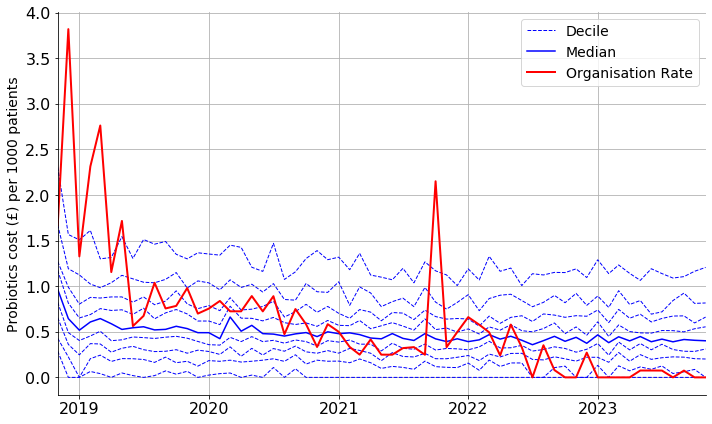

<h4><a href=https://openprescribing.net/measure/probiotics/sicbl/01W>NHS STOCKPORT</a></h4>

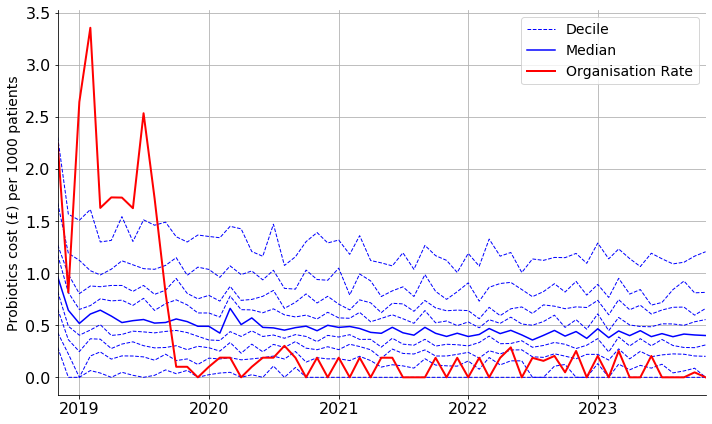

<h2 id=edoxaban><a href=https://openprescribing.net/measure/edoxaban>Proportion of Direct Acting Oral Anticoagulants (DOACs) not prescribed as edoxaban or generic apixaban</a></h2>

<h4><a href=https://openprescribing.net/measure/edoxaban/sicbl/15M>NHS DERBY AND DERBYSHIRE</a></h4>

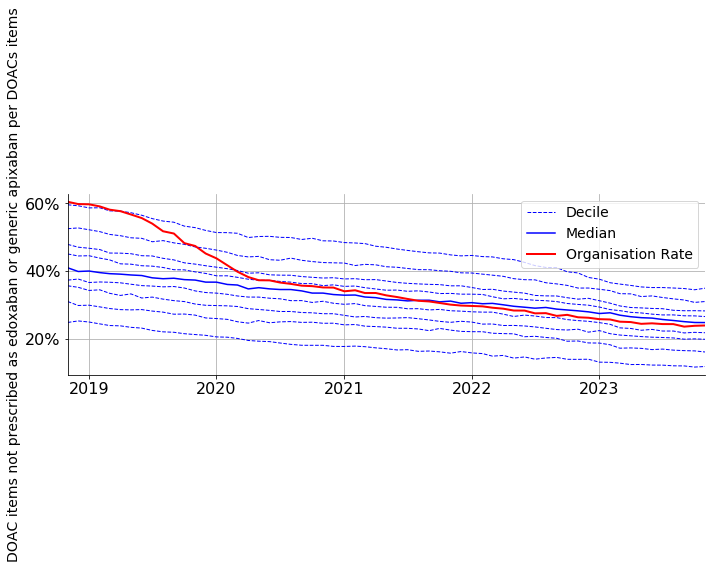

<h2 id=seven_day_prescribing><a href=https://openprescribing.net/measure/seven_day_prescribing>Seven Day Prescribing for Long Term Conditions</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=saba><a href=https://openprescribing.net/measure/saba>Short acting beta agonist inhalers</a></h2>

<h4><a href=https://openprescribing.net/measure/saba/sicbl/02T>NHS CALDERDALE</a></h4>

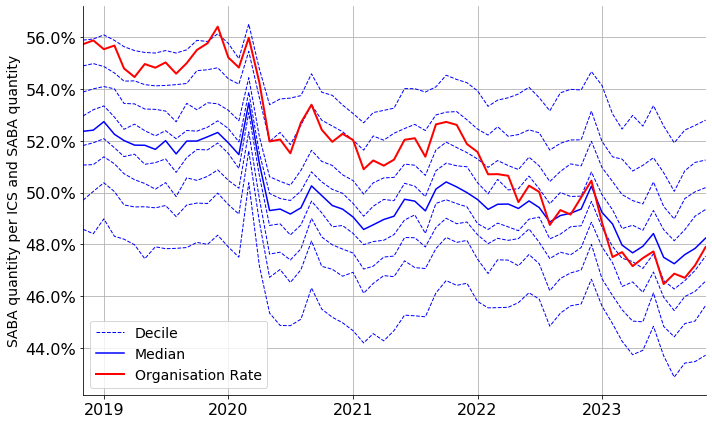

<h2 id=silver><a href=https://openprescribing.net/measure/silver>Silver dressings</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=solublepara><a href=https://openprescribing.net/measure/solublepara>Soluble/effervescent forms of paracetamol and co-codamol</a></h2>

<h4><a href=https://openprescribing.net/measure/solublepara/sicbl/01K>NHS MORECAMBE BAY</a></h4>

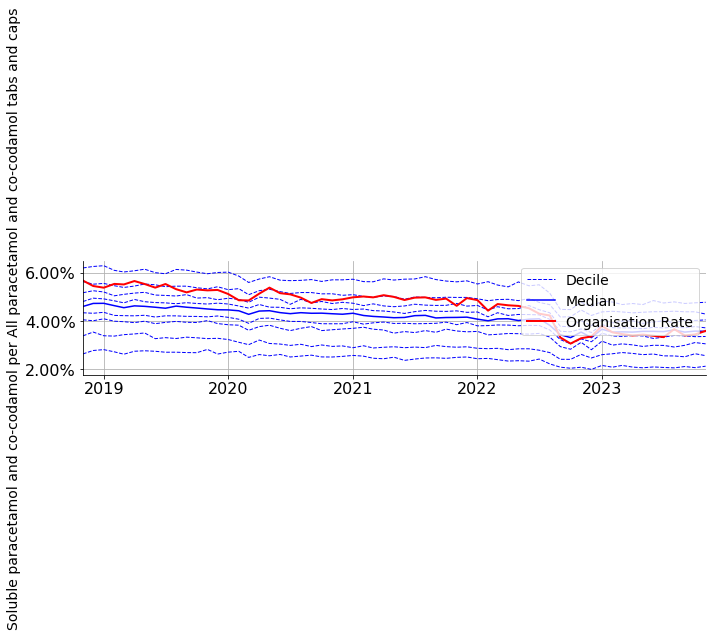

<h4><a href=https://openprescribing.net/measure/solublepara/sicbl/11J>NHS DORSET</a></h4>

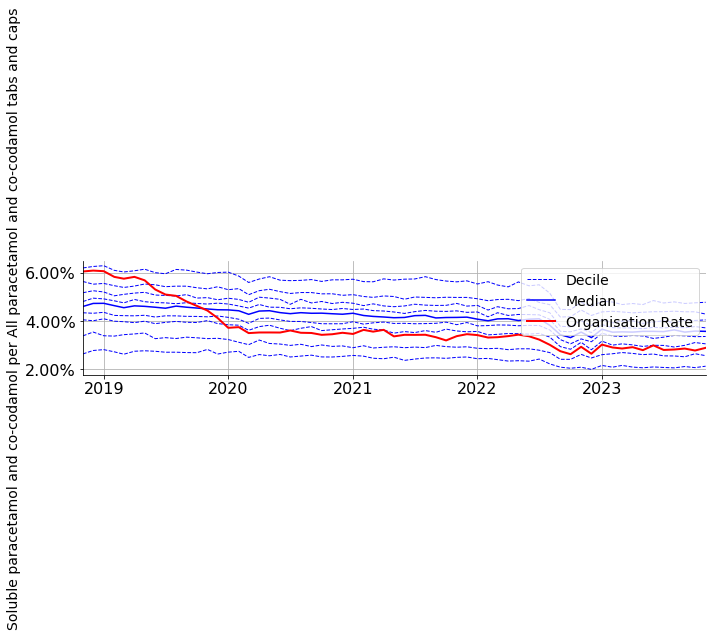

<h2 id=toothpaste><a href=https://openprescribing.net/measure/toothpaste>Toothpaste Prescribing</a></h2>

No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=fungal><a href=https://openprescribing.net/measure/fungal>Topical treatment of fungal nail infections</a></h2>

<h4><a href=https://openprescribing.net/measure/fungal/sicbl/03L>NHS ROTHERHAM</a></h4>

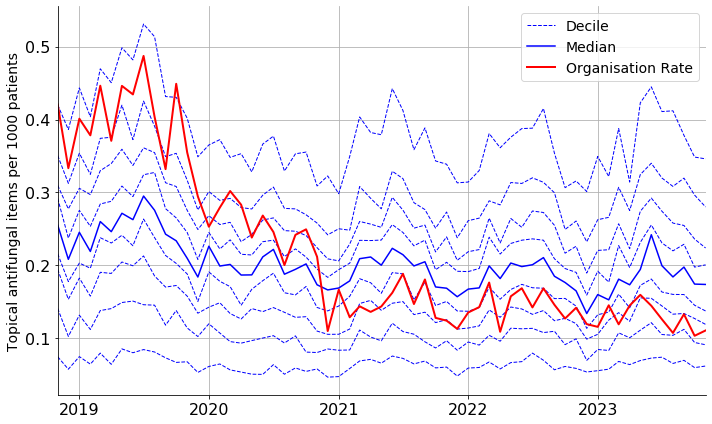

<h2 id=vitbper1000><a href=https://openprescribing.net/measure/vitbper1000>Vitamin B complex per 1000 patients</a></h2>

<h4><a href=https://openprescribing.net/measure/vitbper1000/sicbl/01V>NHS SOUTHPORT AND FORMBY</a></h4>

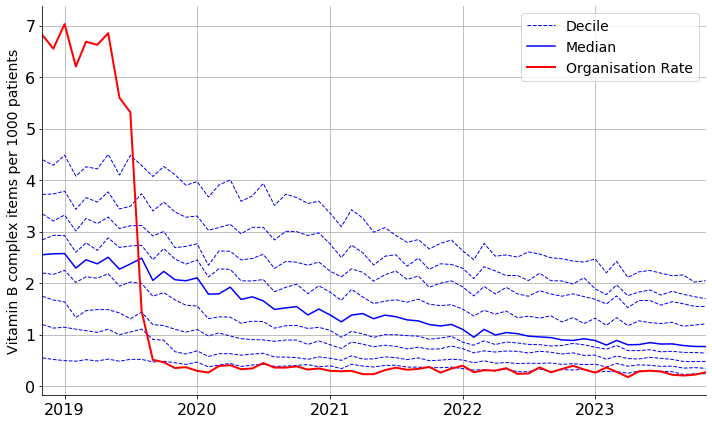

<h4><a href=https://openprescribing.net/measure/vitbper1000/sicbl/01T>NHS SOUTH SEFTON</a></h4>

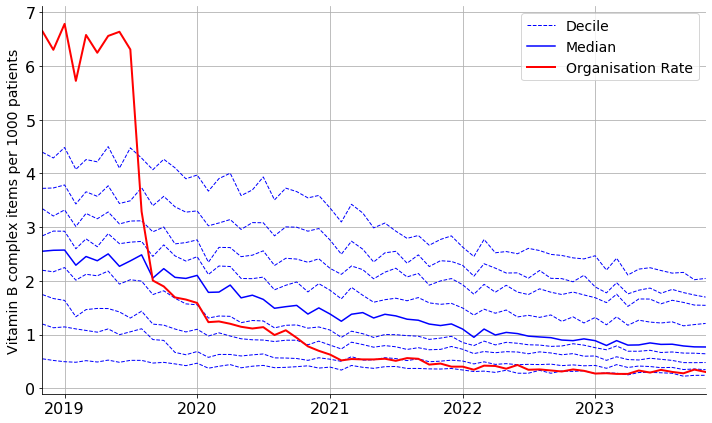

<h4><a href=https://openprescribing.net/measure/vitbper1000/sicbl/01X>NHS ST HELENS</a></h4>

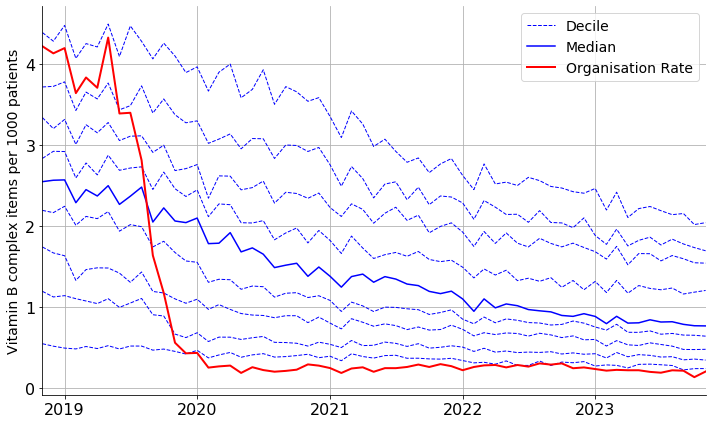

<h4><a href=https://openprescribing.net/measure/vitbper1000/sicbl/01J>NHS KNOWSLEY</a></h4>

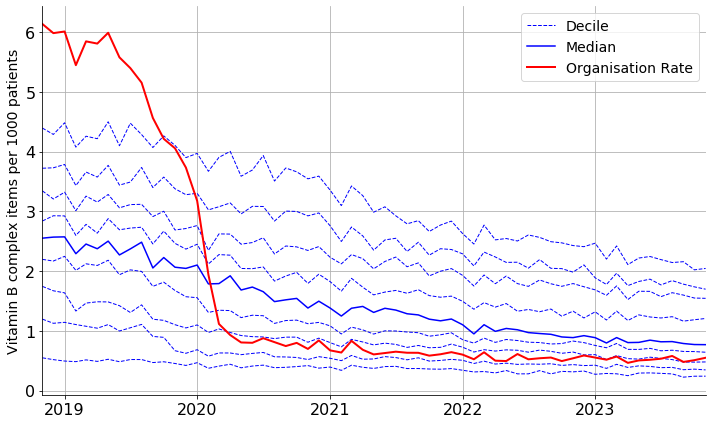

In [22]:
display(Markdown('## Table of Contents'))

measure_list = measure_list.sort_values(by='name') # sort by name
for m in measure_list['measure_name']:
    measure_link = f"https://openprescribing.net/measure/{m}"
    measure_description = measure_list.loc[measure_list["measure_name"] == m, "name"]
    if len(measure_description) > 0:
        measure_description=measure_description.iloc[0]
    
        display(Markdown(f'<a href=#{m}>- {measure_description}</a>'))
        
        
for m in measure_list['measure_name']:
    
    measure_link = f"https://openprescribing.net/measure/{m}"
    measure_description = measure_list.loc[measure_list["measure_name"] == m, "name"]
    percentage = measure_list.loc[measure_list["measure_name"] == m, "is_percentage"].item() # create percentage flag for formatting
    y_string = measure_list.loc[measure_list["measure_name"] == m, "y_string"].item() # create percentage flag for formatting
    if len(measure_description) > 0:
        measure_description=measure_description.iloc[0]
        
        display(Markdown(f'<h2 id={m}><a href={measure_link}>{measure_description}</a></h2>'))
        data = pd.read_csv(DATA_FOLDER / f'ccg_data_{m}/bq_cache.csv', parse_dates=["month"])
        data["rate"] = data["numerator"]/data["denominator"]

        data["percentile"] = data.groupby(["month"])["rate"].rank(pct=True)
    
        deciles = compute_deciles(data, "month", "rate")

        processor = DataFrameProcessor(data, config, verbose=config.get('show_filter_results', False))
        filtered_ccgs = processor.apply_combined_filters()


        num_orgs_identified = len(filtered_ccgs)
        # Main loop to plot CCG data
        if num_orgs_identified > 0:
#             display(Markdown(f"Number of organisations with improvement identified: {num_orgs_identified}"))
            for ccg in filtered_ccgs:
                sicbl_link = f"https://openprescribing.net/measure/{m}/sicbl/{ccg}"
                ccg_name = ccg_names.loc[ccg_names["code"]==ccg, "name"].values[0]
                display(Markdown(f'<h4><a href={sicbl_link}>{ccg_name}</a></h4>'))
                fig = plot_org_data(ccg, data, deciles, percentage, y_string)
                
             
        else:
            display(Markdown("No organisations met the technical criteria for detecting substantial change on this measure."))